# Week 4: Intro to Time Series Models

We will look into the following classes of time series models:
- Holt-Winters Exponential Smoothing models
- Box-Jenkins ARIMA models
- GARCH models
- General State Space models with Kalman Filter algorithms

Despite somehow unorthodox, we'll start with state space models and kalman filter. As will be seen, various time series models can be expressed in a state space representation. 

# Exponential Smoothing Models

Based on and contains exerpts from [Forecasting: Principles and Practice (2nd ed)](https://otexts.com/fpp2/). 

## Overview

Recall that in week 3 we studied a basic exponentially weighted moving average (EWMA) chart for change detection, in which current statistic is expressed as the geometric sum of weighted previous statistics with weight between 0 and 1. In other words, the more recent the observation the higher the associated weight. The Holt-Winters smoothing models are an extension of EWMA models with trends and seasonality components. Smoothing in the context of time series is a rule of thumb technique that involves computing weighed average adjacent samples around $t \pm \delta$. In this setting, selecting and using a forecasting method may appear to be somewhat ad hoc. The selection of the method is generally based on recognising key components of the time series (trend and seasonal) and the way in which these enter the smoothing method (e.g., in an additive, damped or multiplicative manner). 

In the EWMA The forecast for a time series $Y$ at time $T+h$ given information available at time $T$ is given by:
\begin{align*}
\hat{Y}_{T+h|T} &= \sum_{i=0}^T \alpha (1-\alpha)^i y_{T-i}\\
&= \alpha Y_T + (1-\alpha) \hat{Y}_{T|T-1}
\end{align*}

In other words, the geometric sum could be interpreted as a weighted average of information update (weighted by $\alpha$) and previous forecast (weighted by $1-\alpha$), or simply $\alpha$ determines how recent information is valued relative to history. We also see that in the simplest EWMA, the forecast path is flat, i.e. all forecasts take the same value, equal to the last level component for any $h > 0$. Despite the fact that the information is only up to time $T$, we can infer non-stationary components in $Y_t$ including trends and seasonality to provide better forecast in the future. In the Holt-Winters framework, we will represent these components as levels (smoothing), trends, seasonal and a forecast equations that describes how these components combine to form forecasts. We will also see later that trends and seasonality need not be additive. The class of Holt-Winters __E__xponen<b>T</b>ial __S__moothing models can be expressed as <b>ETS</b>(<b>E</b>rror,<b>T</b>rend,<b>S</b>easonality) where the parameters describe setup of error, trend, and seasonal components.

## Trend Methods

#### Linear Trend

[Charles C. Holt](https://en.wikipedia.org/wiki/Charles_C._Holt) extended the simple EWMA model to account for trend components, as follows:

\begin{align*}
\hat{y}_{t+h|t} &= l_t + hb_t & & \text{(forecast equation)}\\
l_t &= \alpha y_t + (1-\alpha) (l_{t-1} + b_{t-1}) & & \text{(level equation)}\\
b_t &= \beta^* (l_t - l_{t-1}) + (1-\beta^*)b_{t-1} & &\text{(trend equation)} 
\end{align*}

Here $\alpha$ and $\beta^*$ are smoothing parameters for the level and trend components, respectively. Note that the trend component is also updated using a weighted average of new information inferred from changes in levels, and previous forecasts. 

#### Damped Trend

A generalization of the linear trend model is the damped trend model. This is motivated by the observations that the linear trend model assumes a constant direction of trend ($hb_t$) and this leads of over-forecast for long forecast horizon. In reality, it is more plausible that short-run forecasts are trended while long-run forecasts are constant - i.e. trend components are not persistent and dissipate (dampen) over time. 

\begin{align*}
\hat{y}_{t+h|t} &= l_t + (\phi + \phi^2 + \cdots + \phi^h) b_t & & \text{(forecast equation)}\\
l_t &= \alpha y_t + (1-\alpha) (l_{t-1} + b_{t-1}) & & \text{(level equation)}\\
b_t &= \beta^* (l_t - l_{t-1}) + (1-\beta^*)b_{t-1} & &\text{(trend equation)} 
\end{align*}

As $h\rightarrow \infty$, $\hat{y}_{t+h|t} = l_t + \frac{\phi b_t}{1-\phi}$, whereas the model approaches the linear trend as $\phi \rightarrow 1$. In practice, the damping parameter $\phi$ is rarely less than 0.8 as the damping has a very strong effect for smaller values. We usually restrict $\phi$ to a minimum of 0.8 and a maximum of 0.98. 

Methods that include a damped trend have proven to be very successful, and are arguably the most popular individual methods when forecasts are required automatically for many series. However, as forecasting tasks can vary by many dimensions (length of forecast horizon, size of test set, forecast error measures, frequency of data, etc.), it is unlikely that one method will be better than all others for all forecasting scenarios. What we require from a forecasting method are consistently sensible forecasts, and these should be frequently evaluated against the task at hand.

## Seasonality Methods

#### Additive Seasonality

Holt and his student Peter Winters later extended the trend methods to account for cyclical components (seasonality) in time series forecasts. Denote the frequency (period) for the seasonal component as $m$ - e.g 4 for quarterly data and 12 for monthly data - we express the extended model as:

\begin{align*}
\hat{y}_{t+h|t} &= l_t + h b_t + s_{t+h-m(k+1)} & & \text{(forecast equation)}\\
l_t &= \alpha y_t + (1-\alpha) (l_{t-1} + b_{t-1}) & & \text{(level equation)}\\
b_t &= \beta^* (l_t - l_{t-1}) + (1-\beta^*)b_{t-1} & &\text{(trend equation)}\\
s_t &= \gamma(y_t - l_{t-1}-b_{t-1}) + (1-\gamma) s_{t-m} & & \text{(seasonal equation)} 
\end{align*}

We see that in the first term of the seasonal equation, the information update is inferred from the variation unexplained by the EWMA level and trend equations, whereas the historical reference value is one period prior to $t$, $t-m$. In the second term, $k = \lfloor \frac{h-1}{m} \rfloor$ so the seasonal forecast always comes from the last cycle in the data. For example, if $h = p m +1$, the predicted seasonal effect will be $s_{t+(pm+1)-m(p+1)} = s_{t-m+1}$. One may note that by substituting the terms in the level equation to the seaonal equation we get:

\begin{align*}
s_t &= \gamma^* (y_t-l_t) + (1-\gamma^*) s_{t-m} \\
\gamma^* &= \alpha(1-\gamma)
\end{align*}

Which conveys essentially the intuition - that variation in $y_t$ unexplained by $l_t$ (which uses information in $y_{t-1}$ and $l_{t-1}$) is attributed to $s_t$. In general, we expect the seasonal additive components to sum to approximate to zero. 

#### Multiplicative Seasonality

One may expect that the seasonal effect will be amplified by the level of $y_t$, one way this happens would be for a seasonal effect to be multiplicative. In this case, we simply rewrite the model as:

\begin{align*}
\hat{y}_{t+h|t} &= (l_t + h b_t) s_{t+h-m(k+1)} & & \text{(forecast equation)}\\
l_t &= \alpha \frac{y_t}{s_{t-m}} + (1-\alpha) (l_{t-1} + b_{t-1}) & & \text{(level equation)}\\
b_t &= \beta^* (l_t - l_{t-1}) + (1-\beta^*)b_{t-1} & &\text{(trend equation)}\\
s_t &= \gamma\frac{y_t}{l_{t-1}-b_{t-1}} + (1-\gamma) s_{t-m} & & \text{(seasonal equation)} 
\end{align*}

We expect the seasonal multiplicative effects to sum to around $m$ within a cycle. It would be useful to have visualizations of the components for model selection purposes. For example, the figure below shows the components for additive and multiplicative season ETS models for the nights spends by tourists in Australia. The varying magnitudes for the additive seasonal component model suggests that the model is less appropriate than the multiplicative model.

<img src="https://otexts.com/fpp2/fpp_files/figure-html/fig-7-LevelTrendSeas-1.png">

In general, we can guess whether the error is additive or multiplicative by studying the magnitude in relation to the level curve.

<img src="http://kourentzes.com/forecasting/wp-content/uploads/2014/11/mseas.fig1_.png">


#### Combinations

Damping is possible with both additive and multiplicative Holt-Winters’ methods. A method that often provides accurate and robust forecasts for seasonal data is the Holt-Winters method with a damped trend and multiplicative seasonality:

\begin{align*}
\hat{y}_{t+h|t} &= \Big(l_t + (\phi + \phi^2 + \cdots + \phi^h) b_t\Big) s_{t+h-m(k+1)} & & \text{(forecast equation)}\\
l_t &= \alpha \frac{y_t}{s_{t-m}} + (1-\alpha) (l_{t-1} + \phi b_{t-1}) & & \text{(level equation)}\\
b_t &= \beta^* (l_t - l_{t-1}) + (1-\beta^*) \phi b_{t-1} & &\text{(trend equation)}\\
s_t &= \gamma\frac{y_t}{l_{t-1}-\phi b_{t-1}} + (1-\gamma) s_{t-m} & & \text{(seasonal equation)} 
\end{align*}

One may have noticed that setups for each components can be mixed and matched. The figure below summarizes the componentization of trends and seasonal treatments for ETS models. They correspond to the second and third parameter in the ETS(E,T,S) notation. Here trends can be either <b>N</b>one, <b>A</b>dditive, or <b>A</b>dditive <b>d</b>amping, whereas seasonality is either <b>N</b>one, <b>A</b>dditive, or <b>M</b>ultiplicative.

<img src="https://otexts.com/fpp2/pegelstable.png" width="75%">

## Error Structure Representation

Recall that previous model representations are in terms of the forecast $\hat{y}_{t+h|h}$. Writing the equations in terms of observable $y_t$, thereby introducing unexplained variation in an error term, can be advantageous. First it extends the functional form in which the error enters the model (e.g. <b>A</b>dditive or <b>M</b>ultiplicative as dictated by the first parameter in ETS(E,T,S)). Where we have distribution assumptions in the error term, MLE can be used readily and the introduction of randomness allows for standard errors and confidence intervals. This representation also allows us to express models in a state space representation which under certain assumptions (e.g. Gaussian error) can be estimated effectively with (extended - if nonlinear measurement) Kalman Filters.

When the error is additive, we express it as $\varepsilon_t = y_t - \hat{y}_{t|t-1}$ and where it is multiplicative, $\varepsilon_t = \frac{y_t - \hat{y}_{t|t-1}}{y_t}$. The figure below listed the state space representation of each ETS model.

<img src="https://otexts.com/fpp2/statespacemodels.png" width="75%">

## Estimation

### Least Squares

The classes of ETS models introduced above can be estimated by the method of least squares, under which the sum of squared errors of forecast made under the information available for each period, $y_t - \hat{y}_{t|t-1}$ is minimized. Note that for smoothing methods in general, we would also need to optimize over the initial values for the smoothed series beside the model parameter $\theta$. For example, for the Holt-Winters method with a damped trend and multiplicative seasonality, the estimation problem is expressed as:

\begin{align*}
\min_{\theta, l_0, b_0, s_0, \ldots, s_{-m+1}} \sum_{t=1}^T \bigg( y_t - \hat{y}_{t|t-1} \bigg)^2
\end{align*}

### MLE

When expressed in state space model representation, we can construct likelihood from $f(\varepsilon)$. If $f()$ is Gaussian, Kalman Filter methods can be used. Estimation of the error variance term, $\sigma$ allows for confidence intervals for forecasts. ETS point forecasts are equal to the medians of the forecast distributions. For models with only additive components and when the forecast distributions are normal, the medians and means are equal. For ETS models with multiplicative errors, or with multiplicative seasonality, the point forecasts will not be equal to the means of the forecast distributions. It is possible to derive the bounds for forecast in $h$ periods in terms of $\sigma$ and model parameters $\theta$, e.g. the bound for ETS(A,N,N) is $\sigma_h^2 = \sigma^2(1+\alpha(h-1))$.


## Model Selection

### CV / Out-of-sample Fit

A one-time CV can be performed as per [this documentation](https://people.duke.edu/~rnau/three.htm), or the figure below.

<img src="https://people.duke.edu/~rnau/randwkf2.gif">

Nested CV can be considered, as per [this medium post](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9)

### Information Criteria

AIC and BIC (where applicable, e.g. distribution assumptions in error) can be used to assess models with respect to their goodness-of-fit and simplicity tradeoff. Recall that the Alkaike and Bayesian information criteria are defined as:

\begin{align*}
AIC &= -2\log(L) + 2k\\
BIC &= -2\log(L) + k \log(T)
\end{align*}

Make sure to include the error variance in $k$, the number of estimated parameters. Note that it is only suitable to use them for comparison across the same class (e.g. within the ETS class), but it's a [myth](https://robjhyndman.com/hyndsight/aic/) that AIC comparison requires nested models.

### Caveats for some ETS specifications

Here are some rules of thumb to keep in mind:

- Three of the combinations of (Error, Trend, Seasonal) can lead to numerical difficulties. Specifically, the models that can cause such instabilities are ETS(A,N,M), ETS(A,A,M), and ETS(A,Ad,M), due to division by values potentially close to zero in the state equations. We normally do not consider these particular combinations when selecting a model.
- Models with multiplicative errors are useful when the data are strictly positive, but are not numerically stable when the data contain zeros or negative values. Therefore, multiplicative error models will not be considered if the time series is not strictly positive. In that case, only fully additive models will be applied.

## Applications

The ETS(M,A,M) specification, which is commonly known as the Holt-Winters triple exponential smoothing model, is shown to perform well in various applications.

- This [blog post series](https://thenewstack.io/author/anaisdotisgeorgiou/page/1) published by the data science team at [InfluxDB](https://www.influxdata.com/) discussed how they found that a Holt-Winters ETS(A,A,M) was able to outperform machine learning models.
- This [2020 paper](http://www.pjoes.com/pdf-100496-44428?filename=Application%20of.pdf) uses a Holt-Winters ETS(M,A,M) model to predict climate parameters in Iran. At the end of the paper, they verified the Gaussian assumptions by studying QQ plots for the fitted residuals.
- A [2016 paper](https://virtusinterpress.org/IMG/pdf/10-22495_rgcv6i1art8.pdf) showed that ETS(M,A,M) (Holt-Winters triple exponential model) performs better in the forecast of car sales in South Africa.

# Box-Jenkins ARIMA Models

## Background

#### Definitions

A time series variable $\{y_t\}$ is <b>strictly stationary</b> if the distribution $F(y_{t_1+\tau}, y_{t_2+\tau}, \ldots, y_{t_n+\tau})$ does not depend on $\tau$. Namely,

\begin{align*}
F(y_{t_1+\tau}, y_{t_2+\tau}, \ldots, y_{t_n+\tau}) = F(y_{t_1}, y_{t_2}, \ldots, y_{t_n}) \text{ for all } \tau, t_1, \ldots, t_n \in \mathbb{R} \text{ and } n\in\mathbb{N}  
\end{align*}

Strict stationarity is perhaps quite strong and is hard to achieve without feasible transformation of the data (if ever possible). Fortunately, the Wold's Theorem would assure that a weaker version of stationarity will suffice for modeling and forecasting. Specifically, if we write $\mu_Y(t) = E[y_t]$ and $ACF(t_1, t_2) = E[(y_{t_1}-\mu_Y(t_1))(y_{t_2}-\mu_Y(t_2))]$, $\{y_t\}$ is <b>covariance stationarity</b> if, 

\begin{align*}
\mu_Y(t+\tau) &= \mu_Y(t)\\
ACF(t_1, t_2) &= ACF(t_1-t_2,0)\\
E[|y_t|^2] &< \infty
\end{align*}

#### Wold's Theorem

Every covariance-stationary time series $\{y_t\}$ can be written as the sum of two time series, one deterministic and one stochastic, formally,

\begin{align*}
y_t = \sum_{j=0}^\infty b_j \varepsilon_{t-j} + \eta_t
\end{align*}

The Wold representation is the unique linear representation where the innovations ($\{\varepsilon_t\}$) are linear forecast errors. Here $\eta_t$ is a (covariance stationary) deterministic time series, such as one represented by a sine wave or an autoregressive series, and $\{\varepsilon_t\}$ is a white noise process that is input to the linear filter $\{b_j\}$ which forms the moving average (possibly infinitely many) component in the first term. 

The class of ARIMA models is motivated by this result - if there is a way to transform a time series to stationary, we can use a deterministic autoregressive model combined with a stochastic moving average model (ARMA) to describe the transformed data. If we denote the lag operator as $L$, an ARMA model can be expressed as:

\begin{align*}
y_t &= \sum_{i=1}^p \phi_i y_{t-i} + \sum_{j=0}^q \theta_j \varepsilon_{t-j}
\end{align*}

[Here](https://stats.stackexchange.com/questions/45026/real-life-examples-of-moving-average-processes) is some intuition behind moving average processes.

## Properties

### Stationarity

If we denote the lag operator by $L$, then we express the ARMA model above by:

\begin{align*}
y_t &= (\phi_1 L + \phi_2 L^2 + \ldots + \phi_p L^p) y_t + (\theta_0 + \theta_1 L + \ldots + \theta_q L^q) \varepsilon_t \\
(1-\Phi(L)) y_t &= \Theta(L) \varepsilon_t
\end{align*}

Recall that in Wold's Theorem we would need the autoregressive part (deterministic component of Wold's decomposition) to be stationary. In other words, we need restrictions on $\Phi(L)$ for this condition to hold. 

#### Proposition (Stationary Condition)

The ARMA(p,q) process is stationary if the roots for $1-\Phi(L)$ lie outside the unit circle.

#### Proof

It is straightforward for AR with order $p=1$: $(1-\phi L) y_t = y_t - \phi y_{t-1} = \Theta(L) \varepsilon_t$ we need $|\phi| < 1$ to have a finite variance and a steady-state distribution. To generalize for any $p \geq 1$, we can express in matrix form below. Without loss of generality, we consider pure AR(p) process:

\begin{align*}
\begin{bmatrix} y_t \\ y_{t-1} \\ \vdots \\ y_{t-p+1} \end{bmatrix} &= 
\begin{bmatrix} \phi_1 & \cdots & \phi_{p-1} & \phi_p \\
1 & \cdots & 0 & 0 \\
\vdots & \ddots & \vdots & \vdots \\
0 & \cdots & 1 & 0
\end{bmatrix}
\begin{bmatrix} y_{t-1} \\ y_{t-2} \\ \vdots \\ y_{t-p} \end{bmatrix}\\
\end{align*}

In compact form, if we do an eigenvalue decomposition on $F = T\Lambda T^{-1}$

\begin{align*}
\xi_t &= F\xi_{t-1} + \varepsilon_t \\
&= F^t\xi_0 + \varepsilon_t + F \varepsilon_{t-1} + \ldots + F^t  \varepsilon_{0}\\
&=T\Lambda^t T^{-1} + \varepsilon_t + T\Lambda T^{-1} \varepsilon_{t-1}  + \ldots + T\Lambda^t T^{-1} \varepsilon_{0}
\end{align*}

Note that:

\begin{align*}
\Lambda^t = \begin{bmatrix} \phi_1^t & 0 & \cdots & 0 \\
0 & \phi_2^t & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & \phi_p^t
\end{bmatrix}
\end{align*}

For the process to be stationary, we need all the eigenvalues for $F$, $|\lambda_j| < 1$. One can show that the eigenvalues are the inverse roots for $1-\Phi(L)$ and $|\lambda_j| < 1$ means that the roots should be outside the unit circle.

### Invertibility

Note that an AR(1) process can be expressed as a MA($\infty$) representation. Conversely, a MA(1) can be <b>inverted</b> to an AR($\infty$) representation:

\begin{align*}
y_t &= \varepsilon_t + \theta \varepsilon_{t-1} \\
\varepsilon_t &= -\theta \varepsilon_{t-1} + y_t \\
&= \sum_{j=0}^\infty (-\theta)^j y_{t-j}
\end{align*}

In order for this invertible result to make sense, we require |$\theta$| < 1. In general, a MA(q) process is invertible if it has an AR($\infty$) representation. Using the same technique in the stationarity proof above, we can conclude that a MA(q) process is invertible if the MA polynomial has all roots outside the unit circle. We care about invertibility of the MA component because we can then express it as AR process which is more convenient for estimation (note $\varepsilon_t$ is unobserved). Also in ARMA applications the imposition of the invertibility condition ensures that there is a unique MA process for a given autocorrelation function.


### Diagnosis Tests

#### Dickey-Fuller Test and Augmented Dickey-Fuller Test for Unit Root

Prior to model estimation, it would be a good idea to test for stationarity of the time series $y_t$ - recall that the Wold's decomposition requires stationarity. The augmented Dickey-Fuller Test provides a statistical inference method for the presence of unit roots. In the original DF test, the following model in two representations are considered:

\begin{align*}
y_t &= \alpha + \beta t \phi y_{t-1} + \varepsilon_t \\
\Delta y_t &= y_t - y_{t-1} = \alpha + \beta t + \gamma y_{t-1} + \varepsilon_t
\end{align*}

The null hypothesis is that $\phi=1$, i.e. the data is a random walk. This translates into $\gamma = 0$. If instead $-1 < 1 + \gamma < 1$ we have a stationary process. We can also have null and alternative hypotheses on $\alpha$ and $\beta$ for other tests (e.g. test for white noise, trends, etc.)

In the augmented DF test, the hypothesis is extended to test against any given lag level $p$,

\begin{align*}
\Delta y_t &= \alpha + \beta t + \gamma y_{t-1} + \sum_{j=1}^{p-1} \delta_j \Delta y_{t-j} + \varepsilon_t
\end{align*}

By including lags of the order $p$ the ADF formulation allows for higher-order autoregressive processes. The intuition behind the test is that if the series is characterised by a unit root process then the lagged level of the series $y_{t-1}$ will provide no relevant information in predicting the change in $y_t$ besides the one obtained in the lagged changes ($\Delta y_t$). In this case $\gamma=0$ and null hypothesis is not rejected. In contrast, when the process has no unit root, it is stationary and hence exhibits reversion to the mean - so the lagged level will provide relevant information in predicting the change of the series and the null of a unit root will be rejected.

#### Ljung-Box Test for Underfitting

The Box-Ljung test (1978) is a diagnostic tool used to test the lack of fit of a time series model. The test is applied to the residuals of a time series after fitting an ARMA(p,q) model to the data. The test examines $h$ autocorrelations of the residuals where $h$ is to be supplied to the test routine. If the autocorrelations are very small, we conclude that the model does not exhibit significant lack of fit. The main idea of the test is that the Ljung-Box test statistic is chi-squared distributed under the null of no autocorrelation (hence, no underfit):

\begin{align*}
n(n+2)\sum_{k=1}^h \frac{\hat{\rho}_k^2}{n-k} \sim \chi^2_h
\end{align*}

The Ljung–Box test is commonly used in autoregressive integrated moving average (ARIMA) modeling. Note that it is applied to the residuals of a fitted ARIMA model, not the original series, and in such applications the hypothesis actually being tested is that the residuals from the ARIMA model have no autocorrelation. When testing the residuals of an estimated ARIMA model, the degrees of freedom need to be adjusted to reflect the parameter estimation. For example, for an ARIMA(p,0,q) model, the degrees of freedom should be set to $h-p-q$.

### Model Selection

Read [this post](http://rinterested.github.io/statistics/acf_pacf.html) for better explanation.

#### Identification of MA model is often best done with the ACF

This should be straightforward to see. For an MA(q) process,

\begin{align*}
\frac{E[y_t y_{t-1}]}{\sigma^2} &= \theta_1 + \theta_1 \theta_2 + \cdots + \theta_1 \theta_{q-1}\\
\frac{E[y_t y_{t-2}]}{\sigma^2} &= \theta_2 + \theta_2 \theta_3 + \cdots + \theta_2 \theta_{q-2}\\
&\vdots\\
\frac{E[y_t y_{t-q}]}{\sigma^2} &= \theta_q\\
\frac{E[y_t y_{t-m}]}{\sigma^2} &= 0 \text{ for all } m > q 
\end{align*}

For example, we would expect to observe the ACF for MA(2) process to have the first two lags significant from zero, as the theoretical ACF looks like:

<img src="https://online.stat.psu.edu/onlinecourses/sites/stat510/files/L02/graph_22.gif">

#### Identification of AR model is often best done with the PACF

The partial autocorrelation function (PACF) might be less straightforward to define than the ACF. In essence, the PACF for lag $p$ is defined as: regress $y_t$ on its first, second, through the $p$-th lag, and obtain the regression coefficients on the $p$-th lagged term. The intuition of PACF for a lag p is the direct influence of the p-th lagged term on the current value after accounting for the cumulative effects from higher order lags. Now we can immediately see why PACF identifies AR structures, because PACF(p) is the $\beta_p$ term from the defining regression:

\begin{align*}
y_t = \beta_0 + \beta_1 y_{t-1} + \cdots + \beta_p y_{t-p}
\end{align*}

Which resembles an AR(p) model. In general, for example, we would expect to observe the PACF for AR(2) process to have the first two lags significant from zero.

#### AIC, BIC

Recall that AIC and BIC are likelihood-based information criterion to measure the tradeoff between goodness-of-fit and simplicity (lower risk of overfitting). They can be used in model selection phase as well. However, note that AIC and BIC are only valid when comparing within the same model class (e.g. different ARMA models), but not across model classes (e.g. ARMA vs Holt-Winters).

#### Model Behavior

Known model behaviors, such as those documented in [this post](https://stats.stackexchange.com/questions/40905/arima-model-interpretation) can be used to inferred the ARMA lags in conjunction to knowledge about the data generating process and heuristic data analysis.

## Estimation

### Transformation

Note that it is essential to transform the data into a stationary series prior to estimating ARMA models. In general, one can do the following to transform a time series data:

- Take difference account for random walks or linear trends. Demean data to remove any drift.
- Take second, or third order differencing to account for quadratic and cubic trends if first differencing did not result in stationarity. We should be [skeptical](https://stats.stackexchange.com/questions/285093/why-does-default-auto-arima-stop-at-5-2-5) about cubic trends because that rarely is the case for real life data.
- Take logarithms to stabilize data. Log-difference also account for changes that are proportional for the level (e.g. constant % change).
- Take seasonal difference (difference by 1 period prior) to deseason the data.
- [Box-Cox transformation](https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203) to induce normality

The flowchart below describes the routines for estimating ARIMA models. We can rely on built-in model selection function available in statistical packages, such as [`auto.arima`](https://www.rdocumentation.org/packages/forecast/versions/8.13/topics/auto.arima). Empirically, ARMA structures (AR and MA simultaneously) are in general hard to identify and complex ARMA models are [hard to interpret](https://stats.stackexchange.com/questions/284648/interpret-arima-models-in-plain-english) so we might prefer simpler models.

<img src="https://otexts.com/fpp2/arimaflowchart.png">

### Season Extension

The ARIMA model can be extended to account for seasonality. If the period of the season cycle is $m$, then the seasonal ARIMA (SARIMA) can be expressed as:

\begin{align*}
& y_t \sim ARIMA(p,d,q)(P,D,Q)_m\\
\Rightarrow & \phi(L)\Phi(L^m)(1-L)^d(1-L^m)^D (y_t - \mu) = \theta(L)\Theta(L^m) \varepsilon_t
\end{align*}

Where $\phi(), \Phi()$ are polynomials of degree $p$ and $P$, and $\theta(), \Theta()$ of degree $q$ and $Q$. For example, consider a simple case, $SARIMA(1,0,0)(0,1,1)_4$, this means that we consider the transformed series obtained with the fourth lagged difference $z_t = y_t - y_{t-4}$ and then we can express the model in terms of $z_t = \phi z_{t-1} + \theta \varepsilon_{t-4} + \varepsilon_t$.

While we can use the ADF test to validate the non-seasonal and seasonal differencing, the identification of seasonal ARMA structures are not always obvious, as seasonal ARIMA models incorporate both non-seasonal and seasonal factors in a multiplicative fashion. Intuitively, we expect to have ACF and PACF that are significant for the non-seasonal lags, and periodically at multiples of the period $m$. However, if the model simultaneously has non-seasonal and seasonal AR (WLOG, MA), the multiplication of the characteristic polynomials implies that the ACF and PACF be also significant at other lags.

For example, the ACF for SARIMA(0,0,1)(0,0,1)[12]:

<img src="https://online.stat.psu.edu/onlinecourses/sites/stat510/files/L04/4.1.ex1_.png" width="50%">

The ACF of 1, 11, and 12 are significant. Significance of the ACF at eleventh lag is actually [expected](https://online.stat.psu.edu/stat510/lesson/4/4.1) becuase the MA(1) structure for $y_{t-11}$ interacts with the periodic lag in the $y_t$ equation. For AR structures, recall that PACF is the regression coefficient, so one just needs to expand and evaluate the characteristic equations.

## Applications

- The [UK Office of National Statistics](http://www.ons.gov.uk/ons/guide-method/ukcemga/publications-home/publications/archive/from-holt-winters-to-arima-modelling--measuring-the-impact-on-forecasting-errors-for-components-of-quarterly-estimates-of-public-service-output.pdf) published a report on its usage of ARIMA in favor of ETS in forecasting various socio-economic series.
- [Some noted](https://stats.stackexchange.com/questions/476424/what-are-the-worst-commonly-adopted-ideas-principles-in-statistics/478558#478558) that ARIMA models are only occasionally useful.

## ARIMA vs ETS

- ARIMA models are theoretically rigorous, and ETS (Holt-Winters) are regarded as somewhat [ad hoc](https://stats.stackexchange.com/questions/476424/what-are-the-worst-commonly-adopted-ideas-principles-in-statistics/478558#478558). However, [some scholars](https://www.sciencedirect.com/science/article/abs/pii/S016920701930086X?via%3Dihub) questioned the empirical effectiveness of ARIMA models.
- ETS tends to be more general. ARMA models require stationarity, but ETS does not.
- One may [test the performance for both](https://otexts.com/fpp2/arima-ets.html), keeping in mind that out-of-sample fit comparison will be vital in assessing each model's forecast ability. For in-sample fit comparison, one should not use AIC and BIC, but resort to more general metrics such as RMSE, MAPE, and MASE.

# Conditional Heteroskedasticity Models

Contains summaries and excerpts from [Analysis of Financial Time Series](https://cpb-us-w2.wpmucdn.com/blog.nus.edu.sg/dist/0/6796/files/2017/03/analysis-of-financial-time-series-copy-2ffgm3v.pdf)) by Ruey Tsay and [Financial Risk Forecasting](https://www.financialriskforecasting.com/) by Jon Danielsson.

# ARCH

The Autoregressive Conditional Heteroskedasticity (ARCH) model is motivated by [Engel (1982)](https://www.jstor.org/stable/1912773?seq=1#metadata_info_tab_contents), who noted that financial time series (UK inflation) should have shocks $\{u_t\}$ that are serially uncorrelated, but exihibit dependence which can be described by a simple quadratic function of its lagged values. Specifically, suppose $\{\varepsilon_t\}_t$ is a iid random variable with zero mean and unit variance (usually standard Normal or standard Student-$t$), we express the shocks in:

\begin{align*}
u_t &= \sigma_t \varepsilon_t\\
\sigma_t &= \alpha_0 + \sum_{j=1}^m \alpha_j u_{t-j}^2
\end{align*}

This is known as the <b>ARCH(m)</b> model. Where $\alpha_0, \alpha_j > 0$ to ensure non-negative variance and the coefficient set $\{\alpha_j\}$ satisfies regularity conditions so that $\{u_t\}$ is stationary (e.g. characteristic roots lying outside unit circle). 

### MLE Estimation 

Assume normality of $\{\varepsilon_t\}$, the <i>conditional</i> likelihood function of the sample under ARCH(m) from samples $t=m+1, \ldots, T$ (recall the full specification is up to the m-th lag):

\begin{align*}
\prod_{t=m+1}^T f(u_{t|t-1}; \sigma_t, \alpha) = \prod_{t=m+1}^T \frac{1}{\sqrt{2\pi\sigma_t^2}} \exp\bigg( -\frac{u_{t|t-1}^2}{2\sigma_t}; \alpha \bigg)
\end{align*}

### Model Selection

$\{u_t\}$ can be raw time series data, such as stock returns. Alternatively, they can be residual estimates used in ARCH(m) can be [obtained from AR(m) residuals](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity#ARCH(q)_model_specification). Since for a single sample, $u_t^2$ are a consistent estimates for $\sigma_t^2$ as $u_t=\sigma_t \varepsilon_t$. The order of ARCH can be determined by PACF of squared residuals (obtained from a fitted time series model). 

The model also has some weaknesses:
   1. The model assumes that positive and negative shocks have the same effects on volatility because it depends on the square of the previous shocks. In practice, it is well known that the price of a financial asset responds differently to positive and negative shocks.
   2. The ARCH model is rather restrictive. For instance, $\alpha_1^2$ of an ARCH(1) model must be in the interval [0, 1/3] if the series has a finite, positive fourth moment. The constraint becomes complicated for higher order ARCH models. In practice, it limits the ability of ARCH models with Gaussian innovations to capture excess kurtosis.
   3. The ARCH model does not provide any new insight for understanding the source of variations of a financial time series. It merely provides a mechanical way to describe the behavior of the conditional variance. It gives no indication about what causes such behavior to occur.
   4. ARCH models are likely to overpredict the volatility because they respond slowly to large isolated shocks to the return series.
   
## Properties

#### Heavy Tail

Fat tails justify the use of ARCH/GARCH models. One can visualize fat tails from QQ plots and sequential moments plot. ARCH model is known to produce empirical distributions with heavy tails - prone to generating outliers. For example, one may evaluate the implied kurosis for $\{u_t\}$ from an ARCH(1) model and verify that it is > 3, the kurtosis of a normal.

Consider the __unconditional__ variance of $u_t$ under the ARCH(1) model:

\begin{align*}
Var(u_t) &= E\big[ E[u_{t|t-1}] \big]\\
&= E[\alpha_0 + \alpha_1 u_{t-1}^2]\\
&= \alpha_0 + \alpha_1 Var(u_{t-1})
\end{align*}

As $\{u_t\}$ is stationary by design ($\sigma_t \varepsilon_t$), we have the steady state variance at $\frac{\alpha_0}{1-\alpha_1}$. Positive variance requires $\alpha_0 > 0, \alpha_1 \in (0,1)$. One may use stataionarity to derive the __unconditional__ fourth moment as well:

\begin{align*}
E[u_t^4] = \frac{3\alpha_0^2(1+\alpha_1)}{(1-\alpha_1)(1-3\alpha_1^2)}
\end{align*}

We see further that $1-3\alpha_1 > 0$ and $\frac{E[u_t^4]}{Var(u_t)^2} > 3$.

#### White Noise

We should note that $\{u_t\}$ arising from ARCH models are white noise. Consider again the ARCH(1) model, we see that under the ARCH framework, large shocks <i>tend to</i> be followed by another large shock - but even so, the level series $\{y_t\}$ (which has shocks/innovations $\{u_t\}$) can still be serially uncorrelated. 

\begin{align*}
E[u_t] &= E[\sigma_t \varepsilon_t] = E_{y_{t-1}}\big[E[\sigma_t \varepsilon_t|y_{t-1}]\big] = E_{y_{t-1}}\big[\sigma_t E[\varepsilon_t|y_{t-1}]\big] = 0\\
E[u_t u_{t+h}] &= E[\sigma_t \sigma_{t+h} \varepsilon_t \varepsilon_{t+h}] = E_{y_{t+h-1}}\big[ \sigma_t \sigma_{t+h} \varepsilon_t E[\varepsilon_{t+h}|y_{t+h-1}] \big] = 0
\end{align*}

#### Forecast

Suppose we have a ARCH(m) model $\sigma_t^2 = \alpha_0 + \alpha_1 u_{t-1}^2 + \cdots + \alpha_m u_{t-m}^2$. The $l$-step ahead forecast from $h$ is:

\begin{align*}
\sigma_{h+1|h}^2 &= \alpha_0 + \alpha_1 u_{h}^2 + \cdots + \alpha_m u_{h-m+1}^2\\
\sigma_{h+2|h}^2 &= \alpha_0 + \alpha_1 u_{h+1|h}^2 + \alpha_2 u_{h}^2 + \cdots + \alpha_m u_{h-m+2}^2 = \alpha_0 + \alpha_1 \sigma_{h+1|h}^2 + \alpha_2 u_{h}^2 + \cdots + \alpha_m u_{h-m+2}^2\\
\vdots &= \vdots\\
\sigma_{h+l|h}^2 &= \alpha_0 + \sum_{i=1}^m \alpha_i \sigma_{h+l-i|h}^2
\end{align*}


# GARCH

On balance, ARCH models are not well suited for capturing volatility. For example, an ACF plot of squared S&P 500 returns shows that 600 lags of squared returns are statistically significant, implying that we would need to estimate an ARCH(600) model to capture the entire volatility structure. This is infeasible, as no estimation package could get even close to estimating an ARCH(600) model; a more practical upper limit might be ARCH(20). A similar problem also exists with autoregressive (AR) models, where it is often solved by introducing a moving average (MA) component. In the context of ARCH, a comparable solution is given
by the GARCH model. One may extend the ARCH(m) model to a GARCH(m,n) model as follows:

\begin{align*}
u_t &= \sigma_t \varepsilon_t\\
\sigma_t^2 &= \alpha_0 + \sum_{j=1}^m \alpha_j u_{t-j} + \sum_{i=1}^n \beta_i \sigma_{t-i}
\end{align*}

While empirically volatile financial time series often require high orders of ARCH model to be adequately described, only lower order <b>G</b>ARCH models are used in most applications, say, GARCH(1,1), GARCH(2,1), and GARCH(1,2) models.
  
## Properties

#### Equivalence to equared ARMA

Write $\eta_t = u_t^2-\sigma_t^2$. We can rewrite the GARCH(m,n) model as:

\begin{align*}
u_t^2 = \alpha_0 + \sum_{i=1}^{\max\{m,n\}} (\alpha_i + \beta_i) u_{t-i}^2 + \eta_t - \sum_{j=1}^n \beta_j \eta_{t-j}
\end{align*}

Which is equivalent to an ARMA($\max\{m,n\}, n$) model on $\{u_t^2\}. 

#### Heavy-tail

We also see that $u_t$ exhibits excess kurtosis. For example, for a GARCH(1,1) model, 

\begin{align*}
\frac{E[u_t^4]}{E[u_t^2]^2} = \frac{3\big(1-(\alpha_1+\beta_1)^2\big)}{1-(\alpha_1+\beta_1)^2-2\alpha_1^2} > 3
\end{align*}

We also see the restriction $0 < \alpha_1+\beta_1 < 1$ for the fourth moment to be positive.

#### Interpretation of GARCH(1,1) coefficients - Memory and Half-Life

The unconditional volatility of the GARCH(1,1) model was given by $\sigma = \frac{1}{1-(\alpha+\beta)}$, but oftentimes a
very small or very large shock to the return process can cause conditional volatility to differ greatly from that number. It is often of interest to identify how long it takes for the impact of the shock to subside. The "memory" of a GARCH model measures how long a shock to the process takes to subside. A measure of memory can be developed by looking at multistep-ahead conditional variance, where $\sigma_{t+2|t}^2$ is the volatility on day $t+2$ given information on day $t$. Another approach is to look at the half-life of a shock (i.e., the number of periods it takes for conditional variance to revert back halfway towards unconditional variance). Note that,

\begin{align*}
E_t[\sigma_{t+2}] &= E_t\big[E_{t+1}[\sigma_{t+2}]\big]\\
&= \sigma^2 + (\alpha + \beta)(\sigma_{t+1|t}^2-\sigma^2)
\end{align*}

In general, we have: $\sigma_{t+n|t}^2 - \sigma = (\alpha + \beta)^{n-1} (\sigma_{t+1|t}^2-\sigma^2)$. Therefore, the half-life for an anticipated shock $\sigma_{t+1|t}^2-\sigma^2$ is:

\begin{align*}
\lambda^* = 1-\frac{\log(2)}{\log(\alpha+\beta)}
\end{align*}

As $\alpha+\beta \rightarrow 1$, the process approaches a noncovariance-stationary process and the half-life diverges to infinity. With daily asset returns, it is common to see values of $\alpha+\beta$ near one; this prompted the development of "long memory" volatility models.

## Model Selection

- Hyperparameters to tune: 
    1. Level model generating $\{u_t\}$: ARMA, mean, or simply the level
    2. Distribution of $\varepsilon_t$: normal, standard $t$, skew $t$
    3. Lags $(m,n)$
- For nested models, do LR test. The null restricted model is equivalent to the unrestricted is tested: $2(L_U-L_R \sim \chi^2(\text{# restrictions})
- Residual analysis with Jarque–Bera test for normality and Ljung-Box test for underfitting.

#### Comments

From stackoverflow posts [here](https://stats.stackexchange.com/questions/175400/optimal-lag-order-selection-for-a-garch-model).

- If one is confined to garch(p,q), then [usually garch(1,1) is what you will want](https://stats.stackexchange.com/questions/20586/automated-parameter-selection-for-a-garch-model-in-a-similar-manner-to-the-fore). Hansen & Lunde ["Does anything beat a GARCH(1,1)?"](http://unstarched.net/2013/01/07/does-anything-not-beat-the-garch11/) compared a large number of parametric volatility models in an extensive empirical study. They found that no other model provides significantly better forecasts than the GARCH(1,1) model.
- On the other hand, the performance of GARCH(1,1) was put to question. Ghalanos argues for the opposite in his blog post ["Does anything NOT beat the GARCH(1,1)?"](http://unstarched.net/2013/01/07/does-anything-not-beat-the-garch11/), illustrating the case with empirical examples. Also, Reschenhofer asks ["Does Anyone Need a GARCH(1,1)?"](http://pubs.sciepub.com/jfa/1/2/2/) and shows that simple robust estimators such as weighted medians of past (squared) returns outperform the GARCH(1,1) model both in-sample as well as out-of-sample.
- Estimate all possible subset models of a GARCH(p,q) model with p, q somewhat large (but not too large -- so that the computations would still be feasible) and choose the best according to an information criterion; use AIC if the model is intended for forecasting; use BIC if the model is intended for explanatory modelling. Also note that when the pool of models gets increasingly larger, AIC and BIC tend to select models that overfit; see Hansen "A winner’s curse for econometric models: on the joint distribution of in-sample fit and out-of-sample fit and its implications for model selection".

## Applications

- [This post](https://towardsdatascience.com/estimating-currency-volatility-using-garch-e373cf82179d) demonstrates a Python implementation of GARCH(1,1) to predict currency volatility.
- [Lecture note](https://jupiter.math.nctu.edu.tw/~weng/seminar/GarchApplication.pdf) documenting use of GARCH models in financial data series.

# EWMA

A simple conditional heteroskedasticity model proposed by JP Morgan is the exponentially weighted moving average:

\begin{align*}
\sigma_t^2 = (1-\lambda) u_t + \lambda \sigma^2_{t-1}
\end{align*}

Evaluating up to $W_E$ periods, 

\begin{align*}
\sigma_t^2 = \frac{1-\lambda}{\lambda(1-\lambda^{W_E})} \sum_{i=1}^{W_E} \lambda^i u_{t-i}^2
\end{align*}

Notice that the weights sum to zero. n it was suggested that $\lambda$ be set at 0.94 for daily returns, and to this day this is the most common assumption.

## Comments

- The main disadvantage of the EWMA model is the fact that $\lambda$ is constant (0.94) and identical for all assets. This implies that it is not optimal for any asset, which is clearly not realistic.
- Note that the EWMA model is a restricted version of GARCH, this by definition gives inferior forecasts compared with GARCH models, even though the difference can be very small in many cases.
- The EWMA model, however, has two key advantages: 
    1. It can be implemented much more easily than most alternatives. 
    2. Multivariate forms can be applied in a straightforward fashion. Coupled with the fact that it often gives reasonable forecasts, EWMA is often the method of choice.
- In general, the EWMA model performs well compared with the more complicated models discussed above.

# State Space Models and Kalman Filter

Based on and contains excerpts from the text by [Nelson and Kim](https://direct.mit.edu/books/book/3265/State-Space-Models-with-Regime-SwitchingClassical),

## Overview

In this section we come to study a class of dynamic (hence involving time series data) linear models known as State Space Models. As we will see, _some variation_ of Holt-Winter Exponential Smoothing models and ARMA models can be expressed under this framework. A state space model involves a state variable defining the underlying system, $\{\beta_t\}$, often unobserved, as well as the following observables: an exogenous vector $\{x_t\}$ and a measurement variable $\{y_t\}$ which is observed. It can be represented in two equations:

\begin{align*}
y_t &= x_t\beta_t + e_t    & &\text{(measurement equation)}\\
\beta_t &= \mu + F \beta_{t-1} + \nu_t & &\text{(system equation)} 
\end{align*}

The measurement equation describes how the latent state variable $\beta_t$ is manifested in the data in terms of observables, and the system equation describes its evolution over time. Note that this model is more flexible than the usual time series models in a sense that the parameter of the model $\beta_t$ is time-variant. Assuming knowledge of $F$ and distributions for $e_t$ and $\nu_t$, $\beta_t$ can be estimated with GLS, or more effectively, Kalman Filter. 

## Kalman Filter: A GLS Motivation

Generalized Least Squares is a regression model allowing for serial correlation and heterogeneity in errors. Recall that if $Var(\varepsilon|X) = \Omega$, then we simply include the inverse in the distance function to offset this covariance structure:

\begin{align*}
& & \min_{b} (y-Xb)^T\Omega^{-1}(y-Xb) & & \\
&\Rightarrow & (-X^T)\Omega^{-1}(y-Xb) + (-X^T)(\Omega^{-1})^T(y-Xb) = 0 & & \bigg(\text{recall }\frac{\partial x^T A x}{\partial x} = (A+A^T)x \text{ and } \frac{\partial Ax}{\partial x} = A^T\bigg) \\
&\Rightarrow & X^T \Omega^{-1}  y = X^T \Omega^{-1}  X b\\
&\Rightarrow & \beta^{GLS} = (X^T\Omega^{-1}X)^{-1}X^T \Omega^{-1} y
\end{align*}

Note that the chain rule is a left multiplication. The feasible GLS (FGLS) involves using a consistent estimate of $\Omega^{-1}$ for empirical implementations. To see how the parameter vector $\{\beta_t\}$ from the linear system above can be estimated, note that the measurement equation is recursively substituted to express all state variables in terms of the latest state $\beta_t$. Assume for now that $\mu = 0$:

\begin{align*}
\beta_t &= F^n \beta_{t-n} + \sum_{m=0}^{m-1} F^m v_{t-m} \\
\beta_{t-n} &= F^{-n} \bigg(\beta_t - \sum_{m=0}^{n-1} F^m v_{t+m}\bigg)\\
&= F^{-n} \beta_t - \sum_{m=0}^{n-1} F^{m-n} v_{t+m} \\
\end{align*}

In vector form, we can write the state vector up to $t$, $\boldsymbol{\beta_t} = [\beta_1, \beta_2, \ldots, \beta_t]^T$ as:

\begin{align*}
\boldsymbol{\beta_t} &\triangleq \Phi(F) \beta_t + \Xi(F, \nu)\boldsymbol{v_t}\\
\end{align*}

So the vectorized measurement equation becomes:

\begin{align*}
\boldsymbol{y_t} &= \boldsymbol{X_t}\boldsymbol{\beta_t} + \boldsymbol{e_t}\\
&= \boldsymbol{X_t} \big(\Phi(F) \beta_t + \Xi(F, \nu)\boldsymbol{v_t}\big) + \boldsymbol{e_t}\\
&\triangleq \boldsymbol{\tilde{X_t}} \beta_t + \boldsymbol{\varepsilon_t}
\end{align*}

Which was transformed to an ordinary linear regression equation. If we further know the distributions for $e_t$ and $\nu_t$, we can construct the (feasible) covariance matrix of the composite error, $\varepsilon$, and estimate each $\beta_t$ by regressing the history of y up to $t$, $\boldsymbol{y_t}$ on the transformed data matrix (up to $t$), $\boldsymbol{\tilde{X_t}}$. Because the GLS estimate for $\beta_t$ uses information up to $t$, we express it as $\beta_{t|t}$ in conjunction to the terminology introduced in sections below. Note that the degree of freedom for each regression is $k$, the dimension of $\{x_t\}$, so the (feasible) GLS can only identify $\beta_t$ for $t$ starting from $k+1$.

While straight foward, one may notice that the matrix $\Phi$, $\Xi$ can get large in size and inverting them could be computationally expensive, rendering GLS computationally infeasible. Kalman Filter, on the other hand, provides a recursive procedure for computing the optimal estimate of the unobserved-state vector without the need for matrix inversion operations.

## Kalman Filter: Overview

Assume that the error terms in the state space model are normally distributed as $e \sim N(0,R)$ and $\nu \sim N(0,Q)$. We define the following notations:

\begin{align*}
\Psi_t &= \{x_\tau, y_\tau\}_{\tau=1}^t    & &\text{Information set at }t\\
\beta_{t|\tau} &= E[\beta_t|\Psi_{\tau}] & & \text{Estimate of $\beta_t$ conditional on $\Psi_{\tau}$ for $\tau \in \{t-1,t,T\}$}\\
P_{t|\tau} &= E\big[(\beta_t-\beta_{t|\tau})(\beta_t-\beta_{t|\tau})^T\big] & & \text{Covariance matrix of $\beta_t$ conditional on $\Psi_{\tau}$ for $\tau \in \{t-1,t,T\}$}\\
y_{t|t-1} &= E[y_t|\Psi_{t-1}] = x_t \beta_{t|t-1} & & \text{Forecast of $y_t$ conditional on $\Psi_{t-1}$}\\
\eta_{t|t-1} &= y_t - y_{t|t-1} & & \text{Prediction error of $y_t$} \\
f_{t|t-1} &= E[\eta_{t|t-1}]^2 & & \text{Conditional variance of prediction error}\\ 
\end{align*}

At each time $t$, the Kalman Filter: 
1. __Prediction:__ before the realization of updated information $\Psi_t\setminus \Psi_{t-1}$, form predictions of states, measurements and covariance $(\beta_{t|t-1}, y_{t|t-1}, P_{t|t-1})$ - implicitly from $t-1$ output from $(\beta_{t-1|t-1}, P_{t|t-1}, \eta_{t|t-1}, f_{t|t-1})$ 
2. __Update:__ once information is updated (realization of $(x_t, y_t)$), evaluate forecast error and its variance, $\eta_{t|t-1}, f_{t|t-1}$ and update estimates to $(\beta_{t|t}, P_{t|t})$
3. __Smoothing:__ do until $t=T$, iterate back to update $(\beta_{t|t}, P_{t|t})$ to $(\beta_{t|T}, P_{t|T})$

### Prediction Equations

Using the dynamic linear system and distribution assumptions, we arrive the following equations for the first step:

\begin{align*}
\beta_{t|t-1} &= \mu + F \beta_{t-1|t-1}    & &\text{System equation}\\
P_{t|t-1} &= F P_{t-1|t-1} F^T + Q & & \nu \sim N(0,Q)\\
\end{align*}

Upon realization of $(x_t, y_t)$, we evaluate the errors:

\begin{align*}
\eta_{t|t-1} &= y_t - x_t \beta_{t|t-1} & & \\
f_{t|t-1} &= x_t P_{t|t-1} x_t^T + R  & & e \sim N(0,R) 
\end{align*}

### Update Equations

We derive the update equations here. First consider the context of update. Now that the information set is updated to $\Psi_t$, how should $(\beta_{t|t-1}, P_{t|t-1})$ be changed? Because conditional on $\Psi_{t-1}$, $\beta_t$ is marginally normal distributed as $\beta_t|\Psi_{t-1} \sim N\big(\beta_{t|t-1}, P_{t|t-1}\big)$ we simply need to update the information set and derive the new distribution. Consider the information update revealed in $\eta_t$, it suffices for us to derive the distribution of $\beta_{t}|\Psi_{t} = \beta_{t}|\Psi_{t-1}, y_t$. Because $(\beta_t, y_t)$ are bivariate normal and it will suffice to find the closed form of the conditional mean.

Now recall that, if $[z_1, z_2]^T$ is bivariate normal, then the conditional mean for $z1$ given $z2$ is: $\mu_1 + \Sigma_{12} \Sigma_{22}^{-1} (z_2-\mu_2)$, and the conditional variance is: $\Sigma_{11}-\Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}$ (see [here](https://www.amherst.edu/system/files/media/1150/bivarnorm.PDF)). Now if we have $[z_1, z_2] = [\beta_{t}, y_{t}]^T$, then conditional on $\Psi_{t-1}$:

\begin{align*}
\mu_1 &= E[\beta_{t}|\Psi_{t-1}] = \beta_{t|t-1}\\
\mu_2 &= E[y_{t}|\Psi_{t-1}] = x_t \beta_{t|t-1}\\
\Sigma_{11} &= Var(\beta_{t}|\Psi_{t-1}) = P_{t|t-1}\\
\Sigma_{12} &= Cov(\beta_{t}, y_t|\Psi_{t-1}) = Cov(\beta_{t}, x_t \beta_{t}|\Psi_{t-1})\\
&= x_t P_{t|t-1} \\
\Sigma_{21} &= \Sigma_{12} = P_{t|t-1} x_t^T\\
\Sigma_{22} &= Var(y_{t}|\Psi_{t-1}) = x_t P_{t|t-1} x_t^T + R = f_{t|t-1}
\end{align*}

Conditional on realized $y_t$ (updated in $\Psi_t$), We have the following __update equations__ as a result:

\begin{align*}
\beta_{t|t} &= \beta_{t|t-1} + P_{t|t-1} x_t^T f_{t|t-1}^{-1} (y_t - x_t \beta_{t|t-1})\\
&\triangleq \beta_{t|t-1} + K_t \eta_{t|t-1}\\
P_{t|t} &= P_{t|t-1}-P_{t|t-1} x_t^T f_{t|t-1}^{-1} x_t P_{t|t-1}\\
&\triangleq P_{t|t-1}-K_t x_t P_{t|t-1}
\end{align*}

### The Kalman Gain

The term $K_t = P_{t|t-1} x_t^T f_{t|t-1}^{-1}$ in the update equations is known as the __Kalman Gain__. To provide an intuition for this term, we consider the simplest case in which the dimension of the state and measurement are both 1. In this case, $f_{t|t-1} = Var(x_t\beta_t-x_t\beta_{t|t-1}+e_t|\Psi_{t-1}) = P_{t|t-1}x_t^2+R$. We see more clearly that, the prediction error consists of two parts: the prediction error $\beta_t - \beta_{t|t-1}$ due to error in making an inference about $\beta_{t}$, and the prediction error due to $e_t$, a random shock to $y_t$ in the measurement equation (measurement error).The Kalman Gain $K$ becomes:

\begin{align*}
K_t = \frac{P_{t|t-1}x_t}{P_{t|t-1}x_t^2+R} = \frac{1}{x_t} \frac{P_{t|t-1}x_t^2}{P_{t|t-1}x_t^2+R}
\end{align*}

Examining the Kalman gain more carefully, we notice that it can be considered as the weight of inference error $\beta_t - \beta_{t|t-1}$ relative to the total error consisting of itself and the measurement error $R$. Now recall that the update equation for the estimate of $\beta_t$ subsequent to realization of $\Psi_t$ is $\beta_{t|t-1} + K \eta_{t|t-1}$. In other words, a weighted average of $\beta_{t|t-1}$ and new information contained in the prediction error $\eta_{t|t-1}$, where the size of update is increasing in inference error. This is quite intuitive, since an increase in uncertainty in $\beta_{t|t-1}$ may be interpreted as a deterioration of the information content of $\beta_{t|t-1}$ relative to that of $\eta_{t|t-1}$.

### Smoothing Equations

When iterative proccess is finished at $t=T$, we can back propagate to previous $t$ to utilize the information from the entire series. Consider now $t = T-1$, now that $\beta_{T|T}$ is known, new information can be used to update the state estimate $\beta_{T-1|T-1}$, as $\beta_{T|T} - \beta_{T|T-1} = \beta_{T|T} - F\beta_{T-1|T-1} - \mu$. The approach will be similar to the derivation of the update equations, by consider a suitable pair of bivariate normal variables $(Z_1, Z_2)$ and evaluate the mean of $Z_1$ conditional on the value $Z_2$ and information $\Psi_{T-1}$. We consider $Z_1 = \beta_{T-1}$ and $Z_2 = \beta_{T}$ which has conditional value at $\beta_{T|T}$.

\begin{align*}
\mu_1 &= E[\beta_{T-1}|\Psi_{T-1}] = \beta_{T-1|T-1} \\
\mu_2 &= E[\beta_{T}|\Psi_{T-1}] = \beta_{T|T-1}\\
\Sigma_{11} &= Var(\beta_{T-1}|\Psi_{T-1}) = P_{T-1|T-1}\\
\Sigma_{12} &= Cov(\beta_{T-1}, \beta_{T}|\Psi_{T-1}) \\
 &= Cov(\beta_{T-1}, F \beta_{T-1} + \mu|\Psi_{T-1}) = P_{T-1|T-1} F'\\
\Sigma_{22} &= Var(\beta_{T|T-1}) = P_{T|T-1}
\end{align*}

Using the same tricks we have $\beta_{T-1|T} = \beta_{T-1|T-1} + P_{T-1|T-1} F' P_{T|T-1}^{-1} (\beta_{T|T} - \beta_{T|T-1})$. Analogous derivation for $P_{T-1|T}$. Using this trick iteratively, we have the following __recursive smoothing equations__:

\begin{align*}
\beta_{t|T} &= \beta_{t|t} + P_{t|t} F' P_{t+1|t}^{-1} (\beta_{t+1|T} - F \beta_{t|t} - \mu) \\
P_{t|T} &= P_{t|t} + P_{t|t} F' P_{t+1|t}^{-1} (P_{t+1|T}-P_{t+1|t}) (P_{t+1|t}^{-1})'  F P_{t|t}'
\end{align*}

#### Discussion of Gaussian Assumption

We have seen that the filtering/update equations rely on Gaussian distribution assumptions for $e$ and $\nu$ - translating to normality of $y$ and $\beta$. A sanity check for this assumption would be to test for normality of the measurement variable under the estimated density $y_t \sim F(.|x_t)$. [This thread](https://stats.stackexchange.com/questions/260996/gaussian-assumption-in-kalman-filter) suggested some tests for Normality. Including, 1. evaluate the normal cdf implied by the state space model, then compare the empirical distribution of $F(.)$ with uniform. 2. A chi-square test with test statistic equal to $(y_t - x_t \beta_t)' (f_{t|t-1})^{-1} (y_t - x_t \beta_t)$, which under the null of normality, should be $\chi^2(k)$ distributed.

Kalman Filter relies on Gaussian distribution and linearity (for state dynamics and measurement process). For example, as noted in [this thread](https://dsp.stackexchange.com/questions/44908/why-does-the-kalman-filter-remove-only-gaussian-noise) KF is only able to remove Gaussian noises. A more general class of models, [Extended Kalman Filters](https://en.wikipedia.org/wiki/Extended_Kalman_filter) is able handle generalized well-defined non-linear dynamics systems. When the data is not Gaussian, however, it is recommended that other models be used (or try transformation of data that would allow Gaussian random noises).

#### Remark on Glossary

"Smoothing" and "Filter" might require some context and information. __Smoothing__ in the context of time series is a rule of thumb technique that involves computing weighed average adjacent samples around $t \pm \delta$. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes. __Filter__ is sometimes used to describe a smoothing procedure. A filter is defined as a set of weights that are applied to a time series. For instance, if the smoothed value for a particular time is calculated as a linear combination of (geometric) observations for surrounding times, it might be said that we’ve applied a linear filter to the data (not the same as saying the result is a straight line, by the way).

Based on the definitions above we see why the update equations are also called smoothing equations - these steps involve taking a weighted average aoround $t$. However it may still not be obvious why KF is filter defined in a time-series sense. To understand its filter nature we could invoke the [recursive filter](https://en.wikipedia.org/wiki/Recursive_filter) definition from the signal processing literature, but this is out of the context of this study note.

### Maximum Likelihood Estimation

#### Initialization

The recursive nature of the Kalman Filter deems initialization of $\beta_{0|0}$ and $P_{0|0}$ necessary. If $\{\beta_t\}$ represents a stationary series and we believe that $t=0$ was when the series was stationary, we can solve for the mean and covariance matrix at the steady state from the system equation. (Note, solving for $P_{0|0}$ involves vectorizing - $vec(FP_{0|0}F')$ to $(F\otimes F) vec(P_{0|0})$). However, if $\{\beta_t\}$ is non-stationary at 0 then we need to impose an initial guess for $\beta_{0|0}$. We can either:

1. Populate $\beta_{0|0}$ with a random guess. By doing so, it is recommended that we assign very large values to the diagonal elements of $P_{0|0}$ so that wild guesses are assigned large uncertainties. In the Kalman gain, inference error will dominate, and information content in $\beta_{t|t-1}$ is treated as negligible.
2. Treat a $\beta_{0|0}$ as an unknown constant vector to be estimated. In this case, we need to set $P_{0|0}$ equal a $k \times k$ zero matrix.

#### Likelihood Function

We take advantage of the Gaussian distribution assumption to derive the likelihood. Note that for each $t$, the dynamic system generates a forecast error $\eta_{t|t-1}$ which is $N(0,f_{t|t-1})$ distributed. Therefore the likelihood for the $t$-th observation is: 

\begin{align*}
\frac{1}{\sqrt{2 \pi f_{t|t-1}}} \exp\bigg\{ -\frac{1}{2} \eta_{t|t-1} f_{t|t-1}^{-1} \eta_{t|t-1} \bigg\}
\end{align*}

For nonstationary series, the likelihood should be evaluated for $t > \tau$ with $\tau >> 1$, yielding the sample log-likelihood as:

\begin{align*}
-\frac{1}{2} \sum_{t=\tau+1}^T \log(2 \pi f_{t|t-1}) - \frac{1}{2} \sum_{t=\tau+1}^T \eta'_{t|t-1} f_{t|t-1} \eta_{t|t-1}
\end{align*}

### Pseudo-Code

In terms of a Python-style pseudo-code, the implementation of a Kalman Filter can be expressed as:

```python
class kalman_filter:
    def __init__(self, b00, P00, state_space_model):
        self.state = b00
        self.cov = P00
        self.model = state_space_model
        self.state_list, self.state_list_ = [], []
        self.P_list, self.P_list_ = [], []
        self.lik = 0
    def eval_error(self, obs):
        self.pred_err = obs.y - self.model.measure(self.state, obs.x)
        self.err_var = obs.x @ self.cov @ obs.x.T + self.model.R
    def evolve(self):
        self.state = self.model.mu + self.model.F @ self.state
        self.cov = self.model.F @ self.cov @ self.model.F.T + self.model.Q
        self.state_list += [self.state]
        self.P_list += [self.cov]
    def update(self, obs):
        K_gain = self.cov @ obs.x.T @ np.linalg.inv(self.err_var)
        self.state += K_gain @ self.pred_err
        self.cov += - K_gain @ obs.x @ self.cov 
        self.state_list_ += [self.state]
        self.P_list_ += [self.cov]
    def eval_lik(self):
        return 1/2 * np.log(2 * np.pi * self.err_var) - 1/2 * self.pred_err.T @ self.err_var @ self.pred_err
    def train(self, data, tau_factor=.5, eval_lik=True):
        self.T = data.shape[0]
        for t in range(self.T):
            self.evolve()                                                              # t-1|t-1 to t|t-1
            obs = state_space_model.obs(data[t,:])
            self.eval_error(obs)                                                       # compute eta and f
            if eval_lik:
                self.lik += self.eval_lik() * (t > tau_factor * self.T)                # compute likelihood
            self.update()                                                              # t|t-1 to t|t
    def smooth(self):
        pred_vec, pred_vec_ = np.array(self.state_list), np.array(self.state_list_)
        err_vec, err_vec_ = np.array(self.P_list), np.array(self.P_list_)
        self.smoothed_state, self.smoothed_err = pred_vec_.copy(), err_vec_.copy()
        for t in range(self.T-2, -1, -1):
            J = err_vec_[t] @ self.model.F.T @ np.linalg.inv(err_vec[t])
            self.smoothed_state[t,:] += J @ (smoothed_state[t+1] - self.model.F @ pred_vec_[t] - self.model.mu)
            self.smoothed_err[t] += J @ (smoothed_err[t+1] - err_vec[t]) @ inv(pred_vec[t]).T @ F @ err_vec_[t]
```

## Examples

- Kalman Filter's smoothing effect is known to be effective at [noise reduction](https://ggbaker.ca/data-science/content/filtering.html) in data, including detrending and deseasonalizing
- An application of Kalman Filter to [detect outliers](https://medium.com/blogyuxiglobal/kalman-filter-the-way-to-remove-outliers-bb6aa616788e)
- Posts [here](https://robotwealth.com/kalman-filter-pairs-trading-r/) and [here](https://www.r-bloggers.com/2010/05/the-kalman-filter-for-financial-time-series/) discuss application on finance
- Kaman Filter also applies to [imputation methods to missing data](https://stats.stackexchange.com/questions/140990/using-kalman-filters-to-impute-missing-values-in-time-series/141385)
- [A comparison](https://stats.stackexchange.com/questions/78287/what-are-disadvantages-of-state-space-models-and-kalman-filter-for-time-series-m) of ARIMA models with state space models
- [A Python notebook](https://www.stat.berkeley.edu/~arturof/Teaching/STAT248/lab10_part1.html#Introduction) on state space models and ETS
- [An ARMA-GARCH Gaussian Mixture for stock price prediction](https://core.ac.uk/download/pdf/48540178.pdf)

# Reading List

- [Nested CV for model selection](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9)
- [Kaggle Kernel on Kalman Filter](https://www.kaggle.com/jigneshjokhakar1/fast-processing-kalman-filter-vs-arima-model)
- [Comments on refitting and rolling estimation with incremental data](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387)
- [A KF polynomial bagging model on weather forecast improvement](https://www.researchgate.net/publication/233997830_Combination_of_Kalman_filter_and_an_empirical_method_for_the_correction_of_near-surface_temperature_forecasts_Application_over_Greece)
- [KF Application for Lyft ride forecasting](https://eng.lyft.com/how-to-deal-with-the-seasonality-of-a-market-584cc94d6b75)
- [Modeling seasonality with Fourier transforms](https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3)

# ISYE 6501 Homework #4

## Jeremy Wong | kwong301@gatech.edu

# Question 7.1

Describe a situation or problem from your job, everyday life, current events, etc., for which exponential smoothing would be appropriate. What data would you need? Would you expect the value of $\alpha$ (the first smoothing parameter) to be closer to 0 or 1, and why?

# Answers to 7.1

A textbook example of exponential smoothing time series would be stock prices. I think the in general we would expect the $\alpha$ closer to 1 than 0, because the prices are derived from the market's expectation of the company's lifetime value. Because the value of a company should be persistent _most of the time_, we'd expect a large part of it a deterministic path of its lagged values, i.e. a smoothing constant closer to 1.

As an exercise, we make use of the `tidyquant` package to download some stock prices (instructions [here](https://www.codingfinance.com/post/2018-03-27-download-price/)) and fit ETS models on them.

We see that Apple, Marathon Oil, and Ford Motor have $\alpha > 0.9$.

In [555]:
library(tidyquant)
library(smooth)

options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)
# Downloading Apple price using quantmod

getSymbols("AAPL", from = '2017-01-01',
           to = "2021-02-17",warnings = FALSE,
           auto.assign = TRUE)
es(ts(AAPL$AAPL.Open, frequency=7), model="AAM", initial="optimal")

[1] "AAPL"

Time elapsed: 0.73 seconds
Model estimated: ETS(AAM)
Persistence vector g:
 alpha   beta  gamma 
0.9704 0.0000 0.0000 
Initial values were optimised.

Loss function type: likelihood; Loss function value: 1905.2203
Error standard deviation: 1.5272
Sample size: 1037
Number of estimated parameters: 11
Number of provided parameters: 2
Number of degrees of freedom: 1026
Information criteria:
     AIC     AICc      BIC     BICc 
3832.441 3832.698 3886.825 3887.720 

In [554]:
getSymbols("MRO", from = '2017-01-01',
           to = "2021-02-17",warnings = FALSE,
           auto.assign = TRUE)
es(ts(MRO$MRO.Open, frequency=7), model="AAM", initial="optimal")

[1] "MRO"

Time elapsed: 1.11 seconds
Model estimated: ETS(AAM)
Persistence vector g:
alpha  beta gamma 
0.936 0.000 0.000 
Initial values were optimised.

Loss function type: likelihood; Loss function value: 485.3304
Error standard deviation: 0.3884
Sample size: 1037
Number of estimated parameters: 11
Number of provided parameters: 2
Number of degrees of freedom: 1026
Information criteria:
      AIC      AICc       BIC      BICc 
 992.6608  992.9183 1047.0457 1047.9400 

In [553]:
getSymbols("F", from = '2017-01-01',
           to = "2021-02-17",warnings = FALSE,
           auto.assign = TRUE)
es(ts(F$F.Open, frequency=7), model="AAM", initial="optimal")

[1] "F"

Time elapsed: 0.71 seconds
Model estimated: ETS(AAM)
Persistence vector g:
 alpha   beta  gamma 
0.9233 0.0000 0.0000 
Initial values were optimised.

Loss function type: likelihood; Loss function value: -278.8485
Error standard deviation: 0.1859
Sample size: 1037
Number of estimated parameters: 11
Number of provided parameters: 2
Number of degrees of freedom: 1026
Information criteria:
      AIC      AICc       BIC      BICc 
-535.6970 -535.4394 -481.3120 -480.4178 

# Question 7.2

Using the 20 years of daily high temperature data for Atlanta (July through October) from Question 6.2 (file temps.txt), build and use an exponential smoothing model to help make a judgment of whether the unofficial end of summer has gotten later over the 20 years.  (Part of the point of this assignment is for you to think about how you might use exponential smoothing to answer this question. Feel free to combine it with other models if you’d like to. There’s certainly more than one reasonable approach.) 

Note: in R, you can use either `HoltWinters` (simpler to use) or the `smooth` package’s `es` function (harder to use, but more general).  If you use `es`, the Holt-Winters model uses model=”AAM” in the function call (the first and second constants are used “A”dditively, and the third (seasonality) is used "M"ultiplicatively; the documentation doesn’t make that clear). 

# Answers to 7.2

## Prelim

First we parse the vectorized data as a `ts` class in R, specifying that the frequency is 123 days.

In [232]:
library(smooth)
library(data.table)
library(magrittr)
library(ggplot2)
library(ggpubr)

library(forecast)
library(aTSA)
library(smooth)

temp0 <- fread("./hw4/temps.txt", header=TRUE)
temp_vec <- temp0 %>% melt(., id.vars="DAY", variable.name="year", value.name="temp")
temp_ts <- temp_vec[, temp] %>% ts(., frequency=nrow(temp0), start=c(1996,1))
print(temp_ts, calendar=TRUE)

      p1  p2  p3  p4  p5  p6  p7  p8  p9 p10 p11 p12 p13 p14 p15 p16 p17 p18
1996  98  97  97  90  89  93  93  91  93  93  90  91  93  93  82  91  96  95
1997  86  90  93  91  84  84  75  87  84  87  84  88  86  90  91  91  89  89
1998  91  88  91  91  91  89  93  95  95  91  91  86  88  87  91  87  90  91
1999  84  82  87  88  90  91  82  86  87  87  82  77  73  81  81  86  82  87
2000  89  91  93  95  96  96  96  91  96  99  96  93  91  93  93  93  91  97
2001  84  87  87  84  86  87  87  89  91  87  90  90  86  82  82  84  87  88
2002  90  90  87  89  93  93  89  89  90  91  84  77  82  88  91  93  93  93
2003  73  81  87  86  80  84  87  90  89  84  84  86  87  84  86  88  88  88
2004  82  81  86  88  90  90  89  87  88  89  90  89  91  91  84  84  84  87
2005  91  89  86  86  89  82  76  88  89  78  83  86  84  87  84  85  89  90
2006  93  93  93  91  90  81  80  82  84  84  90  91  91  91  91  91  93  93
2007  95  85  82  86  88  87  82  82  89  86  85  87  86  84  81  86  89  89

## Decomposition

Next we use the built-in `decompose` function to have a basic inspection of the data. The `decompose` function decomposes a time series x with frequency $f$ into <u>trend</u>, <u>seasonal</u>, and <u>random</u> components according to the following rules of thumb where the trends, seasonality, and errors are additive:

- The trend component $\tau_t$ is defined as the $f$ moving average centered around lag 0, i.e. $\tau_t = \sum_{s=-\lfloor f/2 \rfloor}^{\lfloor f/2 \rfloor} X_{t+s}$ 
- The season component $s_m$ for $1\leq m \leq f$ is defined as the (demeaned) averaged detrended variation in $X_{nf+m}$. Formally, $s_m - \sum_m\frac{s_m}{f}$, where $N$ is the number of complete cycles in the data, and

\begin{align*}
s_m = \frac{\sum_{n=1}^{N} X_{(n-1)f+m} - \tau _{(n-1)f+m}}{N}
\end{align*}

- The random component is simply the unexplained variation $X_t - \tau_t - s_m(t)$

We use an additive decomposition. Unlike financial returns series, cyclical and trend movements are in temperature should manifest in terms of a shift (e.g. global warming, glacial period) instead of an amplification. From the moving average trends panel below, we see that there was a trend in increased temperature around 2010 - as we had discussed in previous homework assignment. The seasonal panel displays a drop in temperature towards the end of window in each year. Our objective for this exercise to test whether the point at which a temperature change is detected, has delayed over the years.

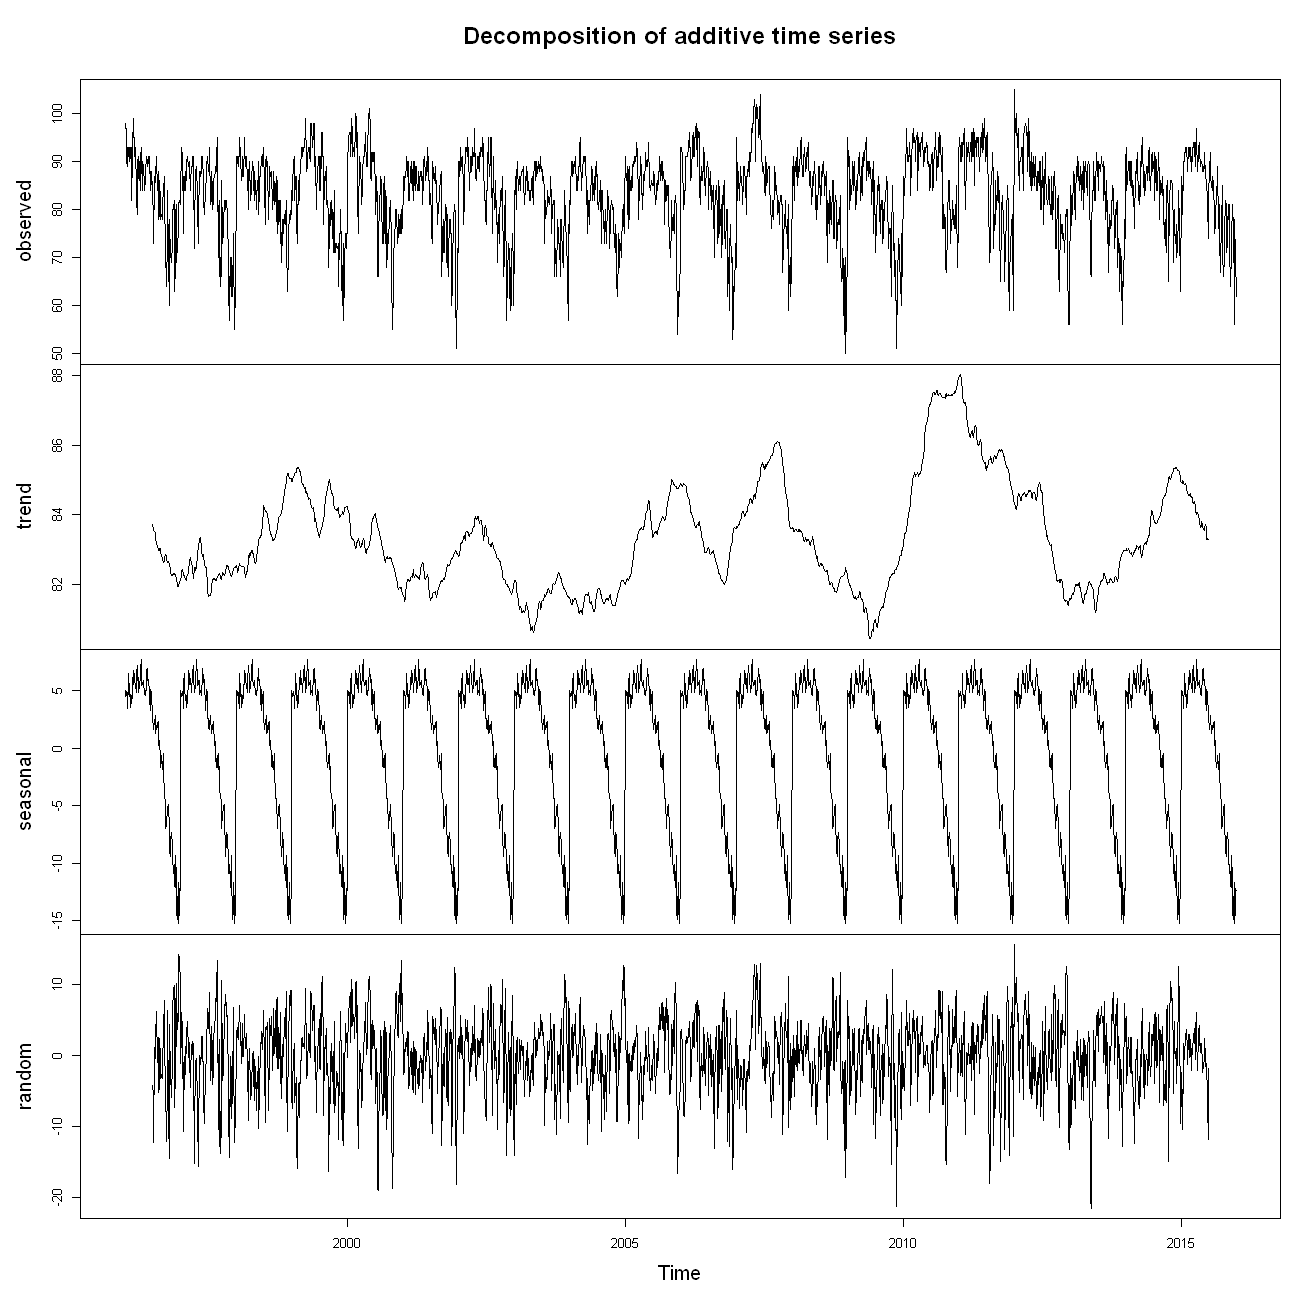

In [105]:
figsize <- 120
options(repr.plot.width = sqrt(figsize), repr.plot.height = sqrt(figsize), repr.plot.res = figsize)

temp_ts_components <- decompose(temp_ts, type = "additive")
temp_ts_components %>% plot

## Build Exponential Smoothing Model

We consider the stacked time series from 7/1 to 10/31 from 1996 to 2015 as a continuous time series data. It is perhaps a bit unnatural that the next period of 10/31/1996 is 7/1/1997. However, we could interpret this as a modeling assumption under the hypothesis that, 7/1 to 10/31 forms a complete cycle. Hetergeneity in overall levels across years should be absorbed by the smoothed levels and trends to filter a normalized seasonal component.

### R Implementation with `es`

Because of its flexibility, we use the `es` function in the `smooth` package to estimate a ETS model. Some syntax, parameters, and output values in the code:

```R
model <- es(data, 
            model="ZZZ", 
            initial=c("optimal","backcasting"), 
            ic=c("AICc","AIC","BIC"), 
            h=10, 
            holdout=FALSE, 
            intervals,
            level=0.95)
```

- `model` follows the ETS(E,T,S) taxonomy of the exponential smoothing model class where: 
    - `E %in% c("A","M")` determines whether the error component is added and multiplied to the model. 
    - `T %in% c("A", "M", "Ad", "N")` determines whether the trend component is additive, multiplicative, multiplicative dampen, or none.
    - `S %in% c("A", "M", "N")` determines whether the seasonality component is additive, multiplicative, or none.
    - Fill in each option slot with `"Z"` to allow for full exploration, `"X"` to restrict exploration on additive tools, `"Y"` to restrict exploration on multiplicative tools. `"C"` estimates all possible options and combine ("bag") them together with AIC weights.
- `initial` determines whether the initial states are estimated along with the ETS equation parameters (`"optimal"`), or imputed `backcasting` which entails reversing the series and reversing the series so that we forecast into the past instead of into the future. Note: [One possible initialization](https://www.sfu.ca/sasdoc/sashtml/ets/chap30/sect7.htm) for the backcast could be obtained by regression with constant and linear terms and seasonal dummies (additive or multiplicative) as appropriate for the smoothing model. 
- `ic` is the model selection criteria (where applicable).
- `holdout` and `h` are the holdout period for forecasting with horizon `h` (functional if `holdout` is `TRUE`).
- `level` and `intervals` are the confidence level and flag for creating them.
- `model$formula` gives the ETS equations for the estimated model.
- `model$states` gives the ETS level, trend, and seasonality components.
- `model$fitted` gives the fitted values for x.
- `model$B` gives the estimated parameters including ETS equation parameters, and initial level, trend, seasonal terms.

### Comparison with `HoltWinters`

We also estimated the ETS model with the built-in `HoltWinters` function in the `stats` package. We compared the SSE of the same models fitted with both functions, and we found that `se` produced better fits than `HoltWinters`. We also attempted to use the `ets` function under `forecast` package, but it is unable to handle data frequency larger than 24. 

According to [this R blog post](https://www.r-bloggers.com/2011/05/comparing-holtwinters-and-ets/), `HoltWinters` ignores restrictions on the parameter space to ensure the resulting model is forecastable, and uses heuristic values for initial states (instead of estimate them). We will prefer `es`.

In [303]:
ets_model_A <- es(temp_ts, model="AAA", initial="optimal")
HW_model_A <- HoltWinters(temp_ts, seasonal=c("additive"), optim.start=c(alpha = 0, beta = 0, gamma = 0))

In [304]:
(temp_ts[124:2460] - HW_model_A$fitted[,1])^2 %>% sum

[1] 66244.25

In [305]:
(temp_ts[124:2460] - ets_model_A$fitted[124:2460])^2 %>% sum

[1] 46506.14

In [283]:
ets_model_M <- es(temp_ts, model="AAM", initial="optimal")
HW_model_M <- HoltWinters(temp_ts, seasonal=c("multiplicative"))

In [286]:
(temp_ts[124:2460]-HW_model_M$fitted[,1])^2 %>% sum

[1] 68904.57

In [287]:
(temp_ts[124:2460] - ets_model_M$fitted[124:2460])^2 %>% sum

[1] 47242.05

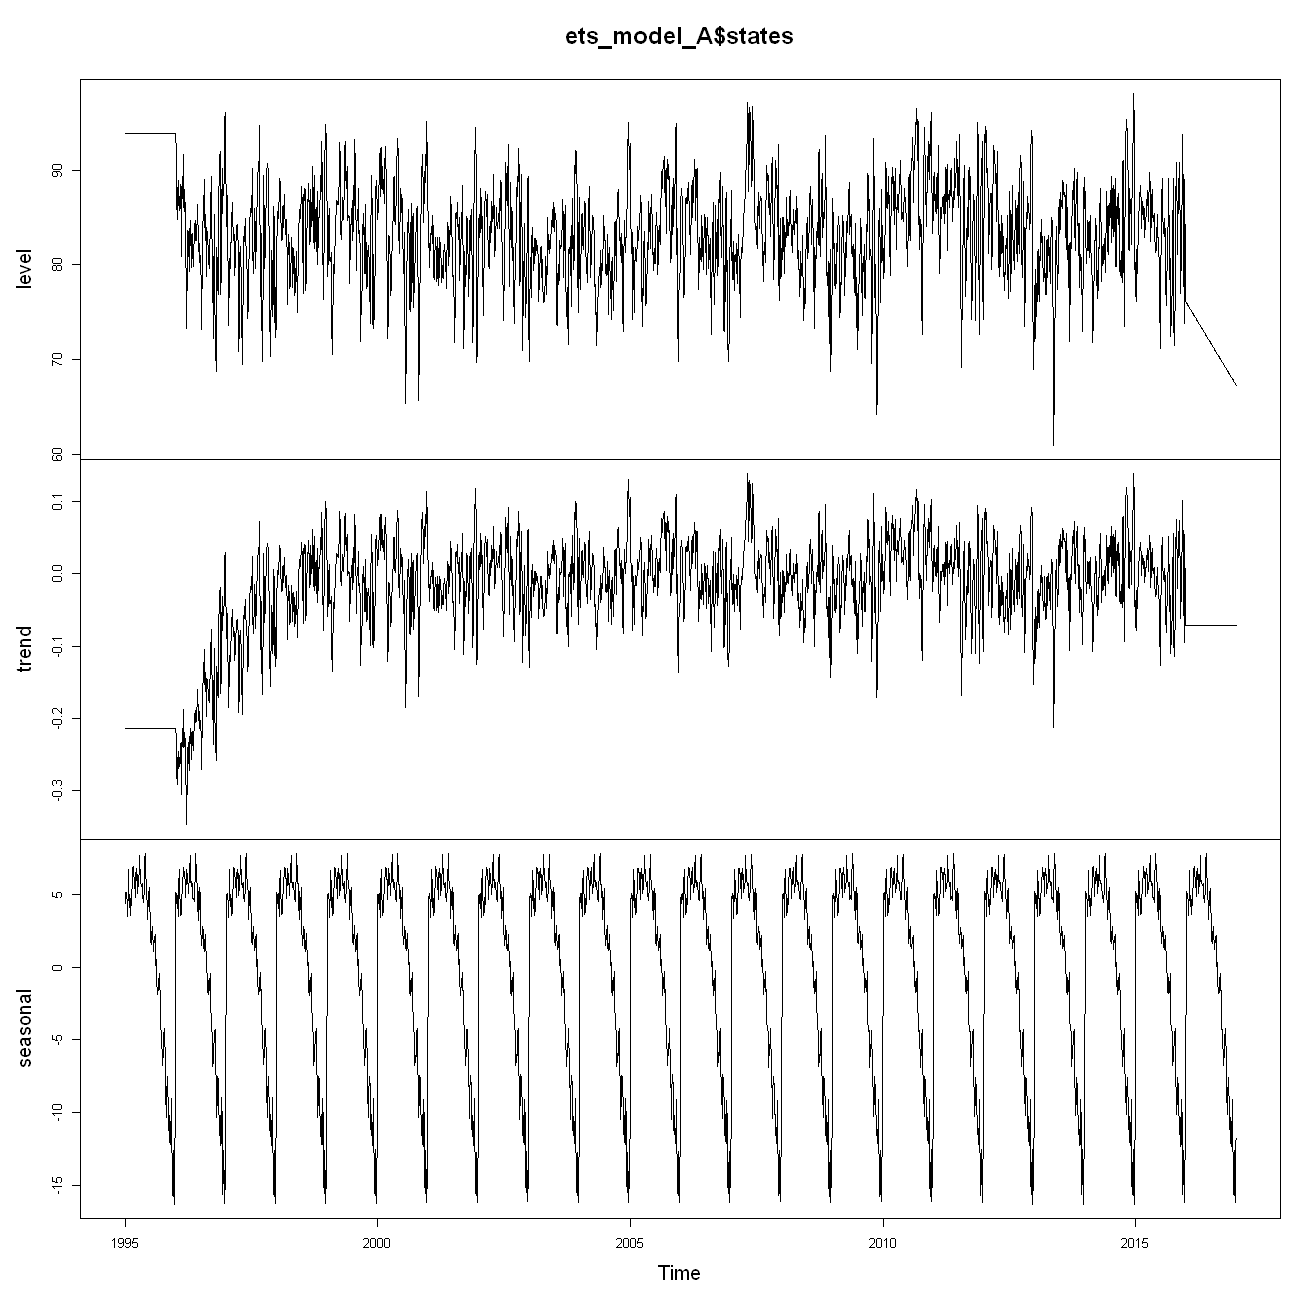

In [292]:
plot(ets_model_A$states)

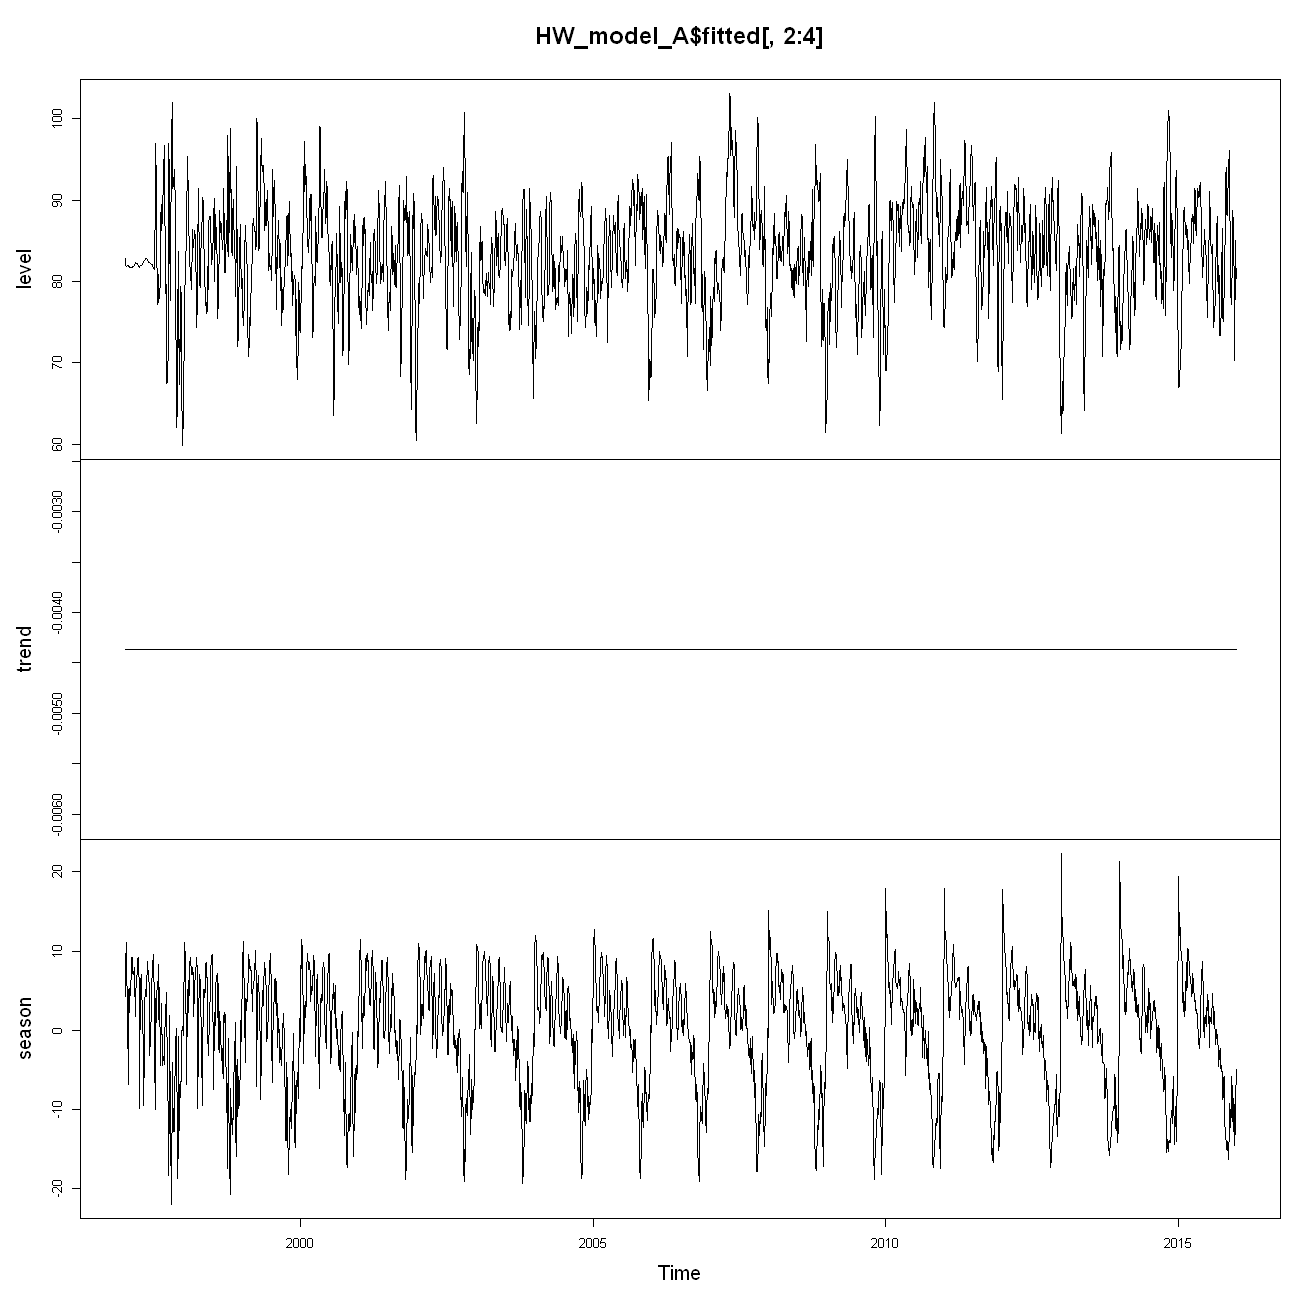

In [330]:
plot(HW_model_A$fitted[,2:4])

## Model Selection

From discussion above advantages of using `es` over `HoltWinters` include flexibility in models, and also enables a model selection routine if the user is unsure what structure is exhibited by the error, trend, and seasonal terms. Because the nature of seasonality in weather series (driven by shifts, instead of amplification of levels), we propose that the seasonality is additive, hence the ETS(A,A,A), formally, 

\begin{align*}
\hat{y}_{t+1|t} &= l_{t} + b_t + s_{t+1-m(k+1)}\\
l_t &= \alpha (y_t-s_{t-m}) + (1-\alpha) (l_{t-1}+b_{t-1})\\
b_t &= \beta^* (l_t-l_{t-1}) + (1-\beta^*) b_{t-1}\\
s_t &= \gamma (y_t - l_{t-1} - b_{t-1}) + (1-\gamma) s_{t-m}
\end{align*}

We should note that ETS is with error structures are often presented as state space model, hence the estimated parameters $\beta$ will be different from the $\beta^*$ above. In terms of state space representation,

\begin{align*}
y_t &= l_{t-1} + b_{t-1} + s_{t-m} + \varepsilon_t\\
l_t &= l_{t-1} + b_{t-1} + \alpha \varepsilon_t\\
b_t &= b_{t-1} + \beta \varepsilon_t \\
s_t &= s_{t-m} + \gamma \varepsilon_t
\end{align*}

This will be our candidate model. In the following code, we will use the `"Z"` option in `es` to explore other combinations of ETS models and compare performances. Because information criterions AIC and BIC are likelihood-based and subject to (unverified) normality assumption, we will simply use SSE as a measure of performance. Note that if the selected model is additive, normality assumption should not be a concern because in this case a least squares will be equivalent to a MLE. 


### Alternative Model

It was found that the best model is ETS(A,N,A). An additive Holt-Winters without trend. We actaully have seen from the graphs above that the trend component is rather weak and insignificant, so we might as well also consider this model alongside the full ETS(A,A,A) specification.

In [341]:
ets_model_Z <- es(temp_ts, model="ZZZ", initial="optimal", loss="MSE")
ets_model_Z

Time elapsed: 19.15 seconds
Model estimated: ETS(ANA)
Persistence vector g:
 alpha  gamma 
0.8022 0.0000 
Initial values were optimised.

Loss function type: MSE; Loss function value: 19.4409
Error standard deviation: 4.5266
Sample size: 2460
Number of estimated parameters: 126
Number of provided parameters: 1
Number of degrees of freedom: 2334
Information criteria:
     AIC     AICc      BIC     BICc 
14532.92 14546.64 14701.25 14701.29 

In [342]:
ets_model_A <- es(temp_ts, model="AAA", initial="optimal", loss="MSE")
ets_model_A

Time elapsed: 1.92 seconds
Model estimated: ETS(AAA)
Persistence vector g:
 alpha   beta  gamma 
0.7400 0.0072 0.0087 
Initial values were optimised.

Loss function type: MSE; Loss function value: 20.0099
Error standard deviation: 4.5954
Sample size: 2460
Number of estimated parameters: 129
Number of degrees of freedom: 2331
Information criteria:
     AIC     AICc      BIC     BICc 
14609.90 14624.30 15359.12 15415.32 

#### SSE

In [338]:
(temp_ts[124:2460] - ets_model_Z$fitted[124:2460])^2 %>% sum

[1] 45061.2

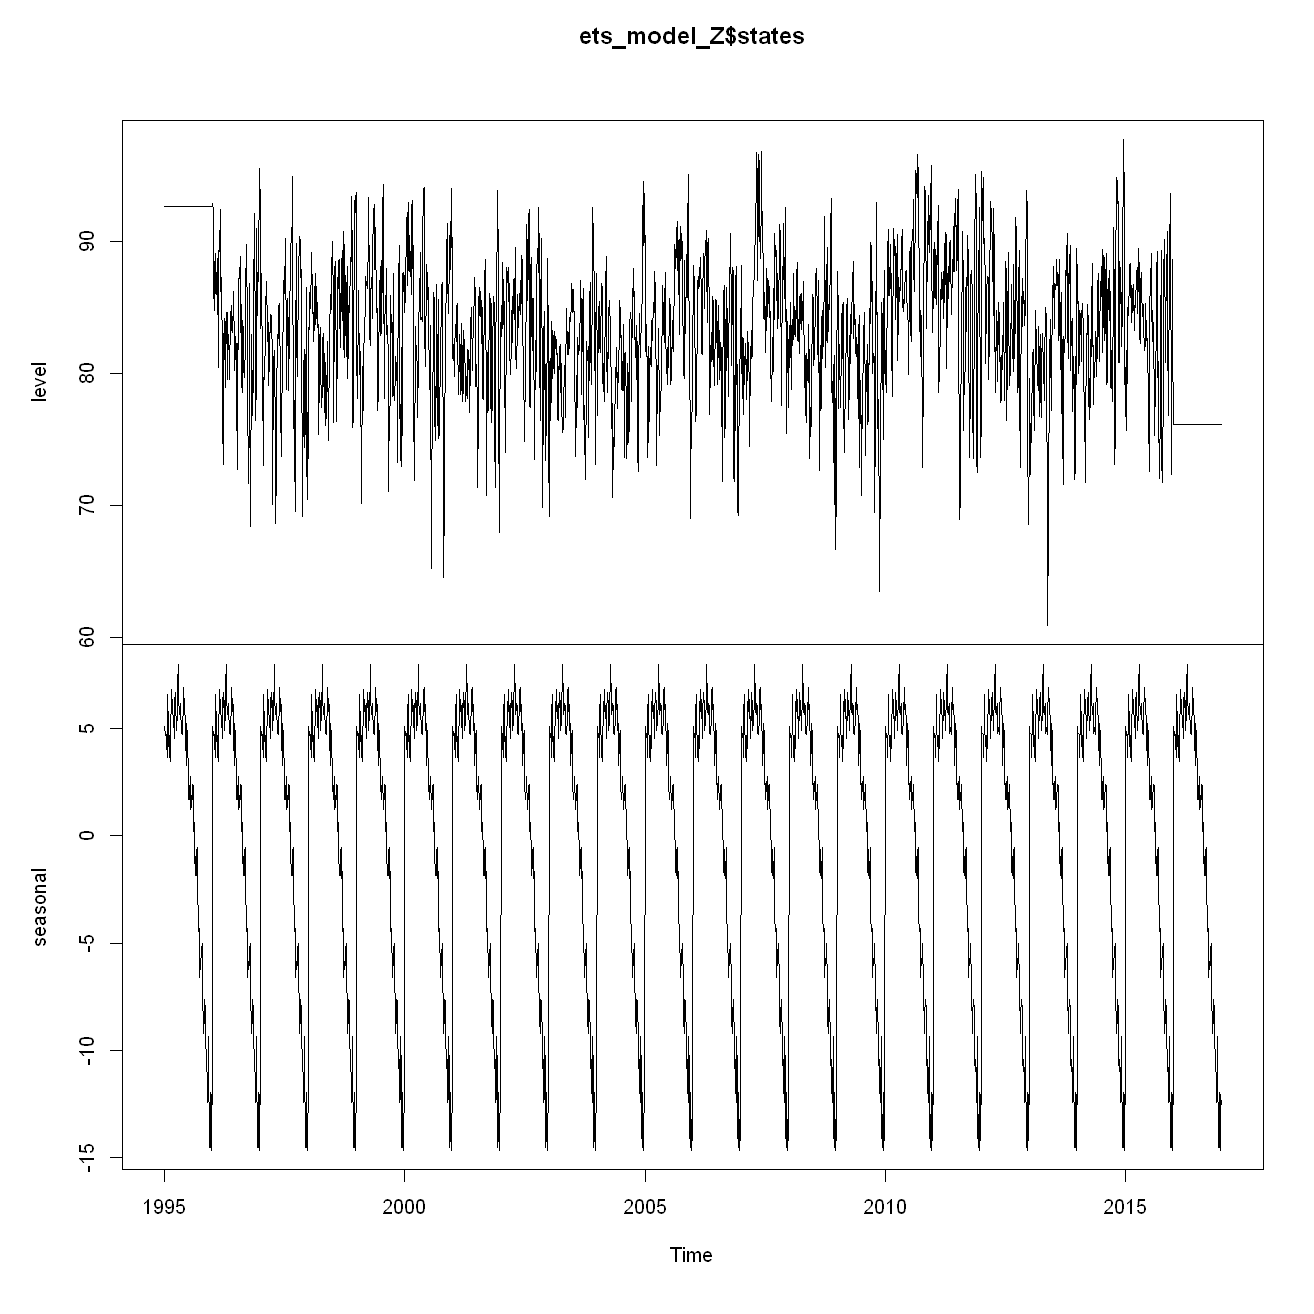

In [300]:
plot(ets_model_Z$states)

## Has End of Summer Delayed? An overview of strategies

We finally address the core question - has the end of summer gotten later over the years? Using the tools we have so far, there are two tools we can approach this question:

1. <b>Change detection mechanisms</b> on the seasonal component of the yearly temperature series. The rationale is that with ETS smoothing, the seasonality component is expected to get rid of noises, trends, and deterministic variation in the level (up to the exponential smoothing functional form). On the contrary, any changes in the seasonality should only reflect variations in the intrinsic seasonal patterns. 
2. <b>A rolling forecast analysis.</b> The idea is to estimate models iteratively: on the first year, then first and second year, then first, second, and third year, so forth. We then study the <u>outputs</u> implied by each model and check if the series exhibit a delay in the changing point as later years were added to the training data. (Note: in this question, the <u>output</u> will be in terms of the CUSUM changing date on the rolling seasonality, we can perhaps come up with other such as inspection of $\hat{y}$ (or its smoothed series) directly).

__Conclusion__: Using a rolling analysis of CUSUM on fitted seasonality, we have found a delay in the end of summer from around October 4 at the beginning of the data, to October 9 at the end of the data.

### CUSUM on yearly seasonality

We first do a CUSUM on the yearly seasonlity extracted by the ETS data. For the ETS(A,N,A), we see that the parameter gamma is 0. That is trivial as we see that the season will be stationary - so there wasn't a delay in end of summer. Now we consider the non-trivial case of ETS(A,A,A). We also see from below that the seasonality component in the fitted ETS(A,A,A) model did not exhibit changes in the seasonal pattern. Here I used the rule of thumb: $T=5\sigma$, $C=0.5\sigma$.

In [513]:
find_cutoff <- function(data, T_factor, C_factor) {
    sig <- sd(data)
    S <- numeric(length(data))
    S[1] <- 0
    for (i in 2:length(data)) {
        s = S[i-1] - (data[i] - mean(data) + C_factor * sig)
        S[i] = s * (s > 0)
    }
    idx <- which(S > T_factor * sig)[1]
    temp0[idx,1][[1]]
}

seasonality <- ets_model_A$states[, 3][124:2583]
cutoff_vec = numeric(20)
for (k in 1:20) {
    cutoff_vec[k] <- find_cutoff(seasonality[(1+(k-1)*123):(k*123)], 5, .5)
}
names(cutoff_vec) <- 1996:2015
print(cutoff_vec)

   1996    1997    1998    1999    2000    2001    2002    2003    2004    2005 
"9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" 
   2006    2007    2008    2009    2010    2011    2012    2013    2014    2015 
"9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" "9-Oct" 


## Rolling CUSUM

We incorporate the spirit of the second approach with the CUSUM analysis. Specifically, as there is a tendency for `es` to estimate a persistent seasonal pattern over the years, we estimate the same ETS(A,A,A) model on a rolling basis and check if the implied (persistent) seasonal patterns imply a delay in the end of summer. In this case, we do observe a delay in the end of summer, in particular ever since we have 2007 in the training data.

In [512]:
for (K in 3:20) {
    cutoff_vec = numeric(K)
    data <- subset(temp_ts, start=1, end=K*123)
    model <- es(data, model="AAA", initial="optimal", loss="MSE")
    seasonality <- model$states[, 3][124:((K+1)*123)]
    for (k in 1:K) {
        cutoff_vec[k] <- find_cutoff(seasonality[(1+(k-1)*123):(k*123)], 5, .5)
    }
    cat(paste0('\n\nEstimating model from 1996 to ', 1996+K-1, '\n\n'))
    names(cutoff_vec) <- 1996:(1996+K-1)
    print(cutoff_vec)
}



Estimating model from 1996 to 1998

   1996    1997    1998 
"2-Oct" "3-Oct" "3-Oct" 


Estimating model from 1996 to 1999

   1996    1997    1998    1999 
"5-Oct" "5-Oct" "5-Oct" "5-Oct" 


Estimating model from 1996 to 2000

   1996    1997    1998    1999    2000 
"5-Oct" "5-Oct" "5-Oct" "5-Oct" "5-Oct" 


Estimating model from 1996 to 2001

   1996    1997    1998    1999    2000    2001 
"4-Oct" "4-Oct" "4-Oct" "4-Oct" "4-Oct" "4-Oct" 


Estimating model from 1996 to 2002

   1996    1997    1998    1999    2000    2001    2002 
"6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" 


Estimating model from 1996 to 2003

   1996    1997    1998    1999    2000    2001    2002    2003 
"6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" 


Estimating model from 1996 to 2004

   1996    1997    1998    1999    2000    2001    2002    2003    2004 
"6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" 


Estimating model from 1996 to 2005

   1996   

#### Robustness Check

We run the ETS(A,N,A) specification, and find similar pattern.

In [514]:
for (K in 3:20) {
    cutoff_vec = numeric(K)
    data <- subset(temp_ts, start=1, end=K*123)
    model <- es(data, model="ANA", initial="optimal", loss="MSE")
    seasonality <- model$states[, 2][124:((K+1)*123)]
    for (k in 1:K) {
        cutoff_vec[k] <- find_cutoff(seasonality[(1+(k-1)*123):(k*123)], 5, .5)
    }
    cat(paste0('\n\nEstimating model from 1996 to ', 1996+K-1, '\n\n'))
    names(cutoff_vec) <- 1996:(1996+K-1)
    print(cutoff_vec)
}



Estimating model from 1996 to 1998

   1996    1997    1998 
"5-Oct" "5-Oct" "5-Oct" 


Estimating model from 1996 to 1999

   1996    1997    1998    1999 
"6-Oct" "6-Oct" "6-Oct" "6-Oct" 


Estimating model from 1996 to 2000

   1996    1997    1998    1999    2000 
"6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" 


Estimating model from 1996 to 2001

   1996    1997    1998    1999    2000    2001 
"5-Oct" "5-Oct" "5-Oct" "5-Oct" "5-Oct" "5-Oct" 


Estimating model from 1996 to 2002

   1996    1997    1998    1999    2000    2001    2002 
"4-Oct" "4-Oct" "4-Oct" "4-Oct" "4-Oct" "4-Oct" "4-Oct" 


Estimating model from 1996 to 2003

   1996    1997    1998    1999    2000    2001    2002    2003 
"7-Oct" "7-Oct" "7-Oct" "7-Oct" "7-Oct" "7-Oct" "7-Oct" "7-Oct" 


Estimating model from 1996 to 2004

   1996    1997    1998    1999    2000    2001    2002    2003    2004 
"6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" "6-Oct" 


Estimating model from 1996 to 2005

   1996   

### Visualization

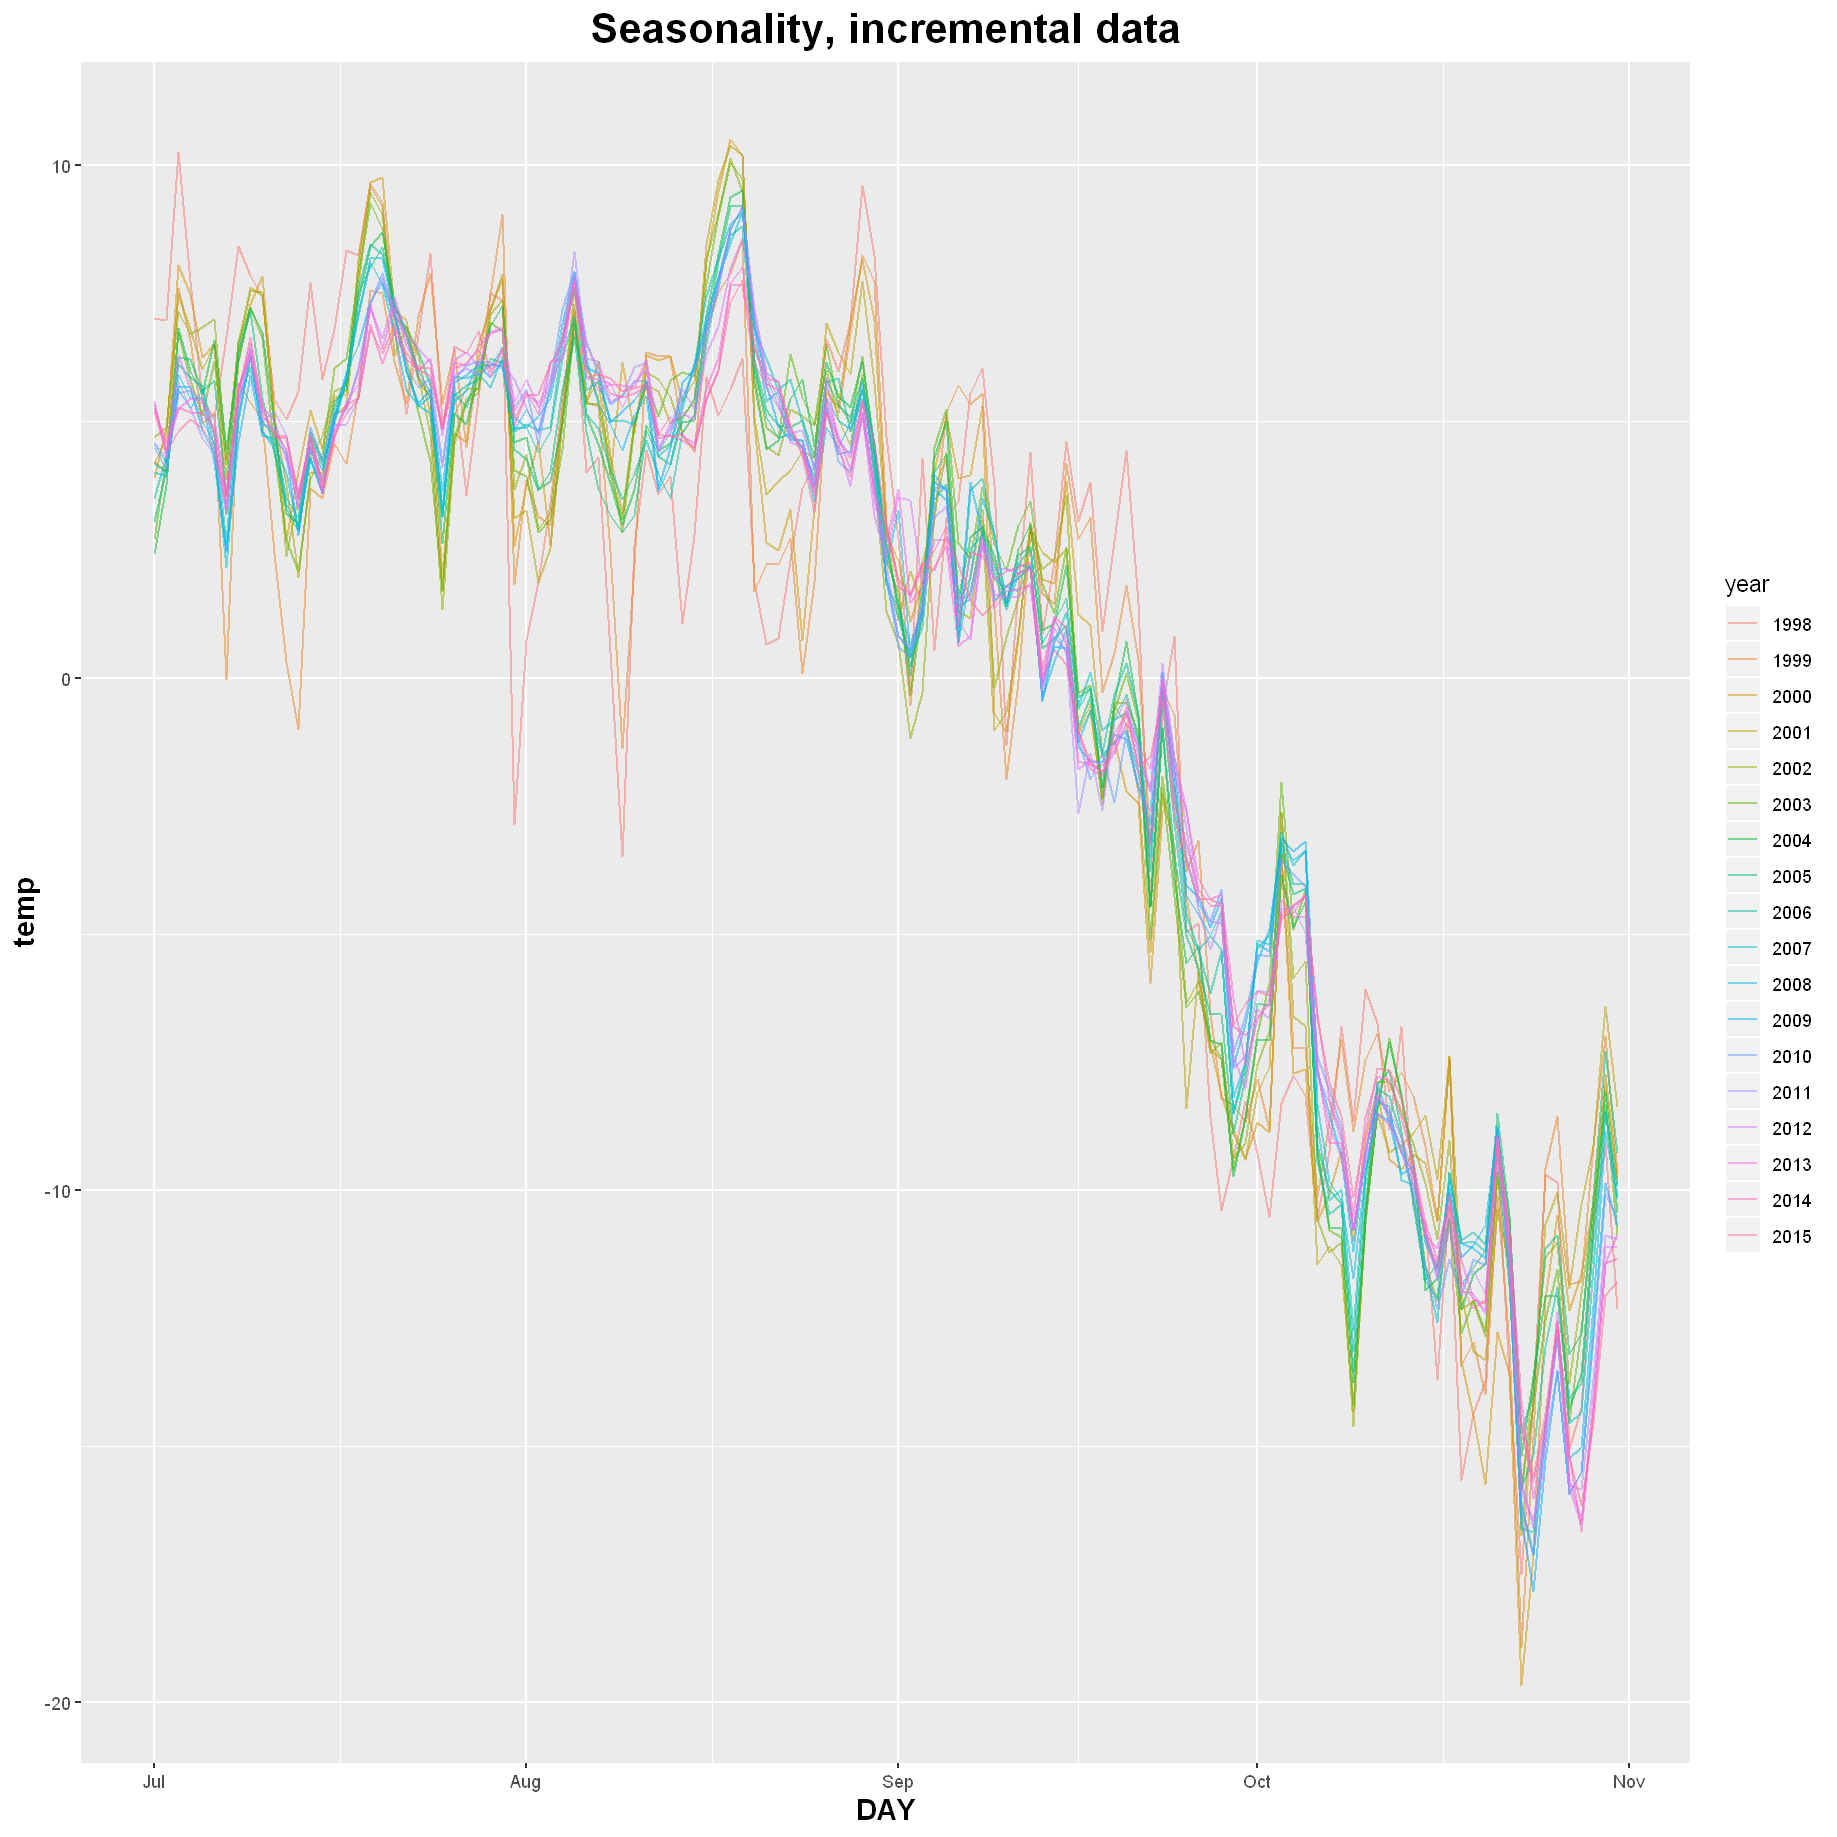

In [511]:
sea_dat <- temp0[, .(DAY)]
sea_dat[, DAY:=as.Date(DAY, format('%d-%b'))]
for (K in 3:20) {
    cutoff_vec = numeric(K)
    data <- subset(temp_ts, start=1, end=K*123)
    model <- es(data, model="AAA", initial="optimal", loss="MSE")
    sea_dat[, as.character(1996+K-1):=model$states[, 3][(K*123+1):((K+1)*123)]]
}
sea_dat %<>% melt(., value.name="temp", variable.name="year", id.vars="DAY")

figsize <- 150
options(repr.plot.width = sqrt(figsize), repr.plot.height = sqrt(figsize), repr.plot.res = figsize)
ggplot() + geom_line(data=sea_dat, aes(x=DAY, y=temp, color=year, group=year), alpha=0.5) + ggtitle("Seasonality, incremental data") +
theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 20), 
      axis.title.x=element_text(face = "bold", size = 14),
      axis.title.y=element_text(face = "bold", size = 14))